--- Training Comparison (K=5, D=4, Epochs=300, Dynamic Noise=0.1) ---
SDE Conv Parameters: 137
Baseline Conv Parameters: 284


Training:  26%|██████████████████▋                                                    | 79/300 [00:01<00:02, 91.37it/s]

Iteration 50/300: SDE Loss=0.130842, Baseline Loss=0.094316


Training:  42%|████████████████████████████▊                                        | 125/300 [00:01<00:01, 124.78it/s]

Iteration 100/300: SDE Loss=0.076860, Baseline Loss=0.040842


Training:  57%|███████████████████████████████████████▎                             | 171/300 [00:02<00:00, 137.30it/s]

Iteration 150/300: SDE Loss=0.051973, Baseline Loss=0.011500


Training:  76%|████████████████████████████████████████████████████▋                | 229/300 [00:02<00:00, 136.14it/s]

Iteration 200/300: SDE Loss=0.033955, Baseline Loss=0.003876


Training:  91%|██████████████████████████████████████████████████████████████▌      | 272/300 [00:03<00:00, 138.06it/s]

Iteration 250/300: SDE Loss=0.022834, Baseline Loss=0.003961


Training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 93.08it/s]


Iteration 300/300: SDE Loss=0.016788, Baseline Loss=0.003124

Final Evaluation:
Initial Noise MSE: 0.010561 (This value varies due to dynamic noise)
SDE Conv Final MSE: 0.016788 (Reduction: 0.63x)
Baseline Conv Final MSE: 0.003124 (Reduction: 3.38x)
SDE Conv Improvement over Baseline: 0.19x

Learned SDE Dynamics Summary (Max Absolute Value):
raw_alpha_l (Decay): Max_Abs=0.666423
raw_alpha_r (Decay): Max_Abs=0.666423
omega_l (Rotation): Max_Abs=0.839577
omega_r (Rotation): Max_Abs=0.839577
Learned Noise Scales: Process_Noise_Var (sigma_x^2)=1.503251, Measurement_Noise_Var (eta^2)=0.727313


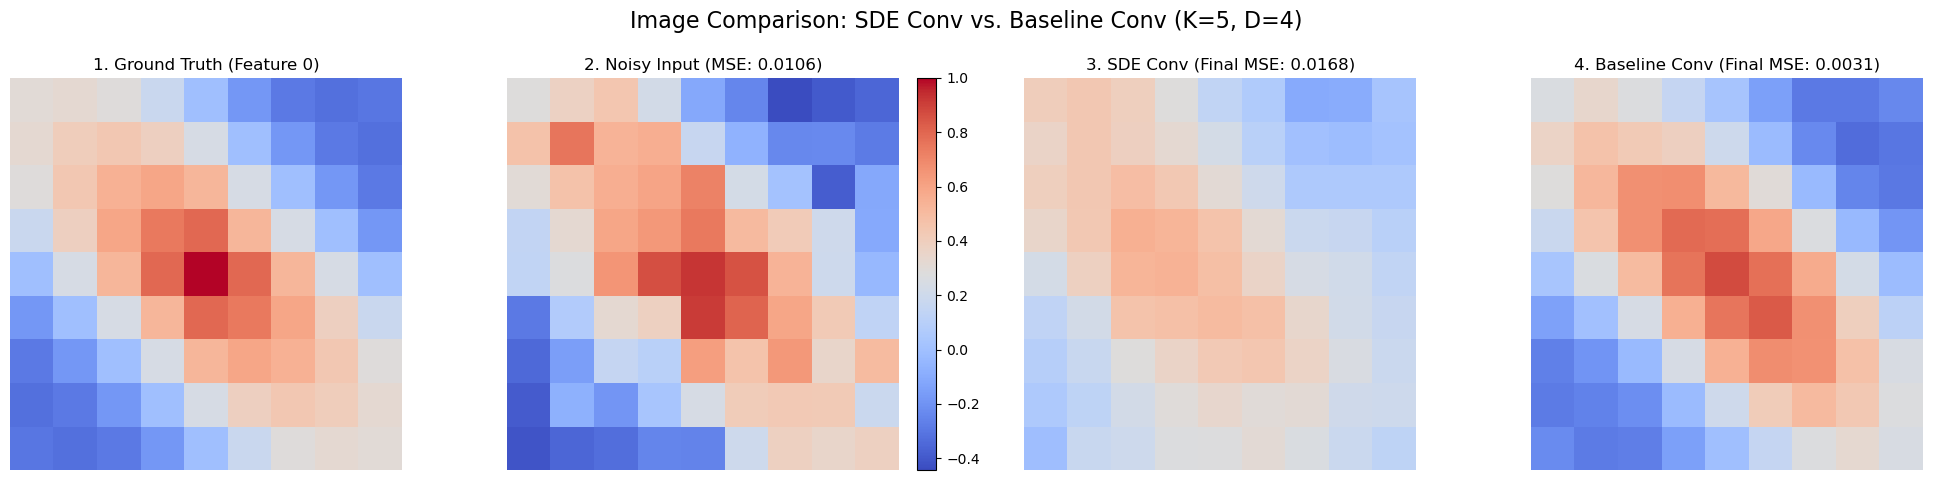

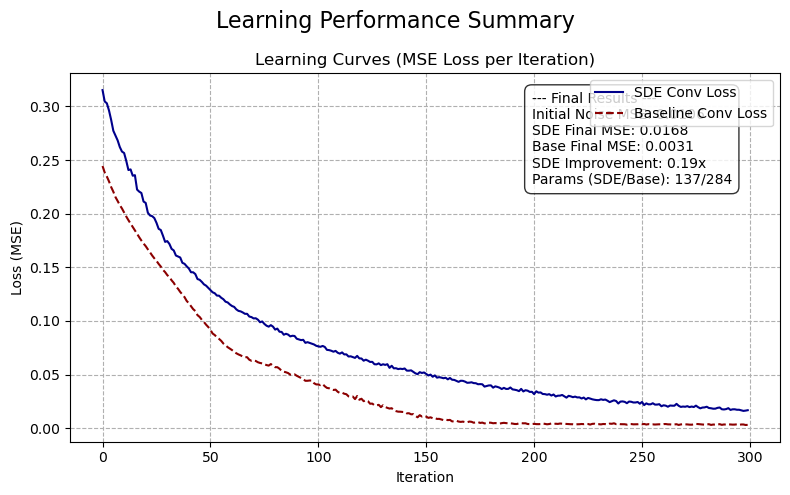

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. Utility Functions ---

def create_sde_ground_truth(H, W, D, alpha_sq, omega_y):
    """
    Generates the ground-truth feature map (X_gt) based on SDE propagation from the center.
    This function creates the signal only, no noise is added.
    """
    alpha_sq = alpha_sq.view(1, D)
    omega_y = omega_y.view(1, D)
    
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    center_x = (W - 1) / 2.0
    center_y = (H - 1) / 2.0
    
    Delta_X_prime = x_coords - center_x
    Delta_Y_prime = y_coords - center_y
    
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p')
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)
    
    # Propagate Seed to Create Ground Truth Signal
    Z_seed_r = torch.ones(1, D) * 5.0
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = (Phi_r * Z_seed_r).unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # Normalize X_gt to max magnitude 1.0
    if X_gt.abs().max() > 1e-6:
        X_gt = X_gt / X_gt.abs().max()
    
    return X_gt

def add_measurement_noise(X_gt, noise_scale):
    """Adds fresh measurement noise to the ground truth signal."""
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    return X_noisy


# --- 2. SDE Convolution Helper Classes ---

class RealToComplexLinear(nn.Module):
    """Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i + (b_r + i b_i)."""
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.b_r = nn.Parameter(torch.zeros(d_model))
        self.b_i = nn.Parameter(torch.zeros(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Z_r = (X @ self.W_r) + self.b_r
        Z_i = (X @ self.W_i) + self.b_i
        return torch.stack([Z_r, Z_i], dim=0) # (2, ..., D)

class ComplexToRealLinear(nn.Module):
    """Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}) + c_r."""
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.c_r = nn.Parameter(torch.zeros(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T) + self.c_r
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """Generates relative positions Delta p' for all pairs of pixels."""
    def __init__(self):
        super().__init__()

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Delta_P = p_a - p_b (Displacement from source b to anchor a)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation using
    precision-weighted averaging.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2
        
        # Learnable Precision weighting constants (as raw positive values)
        self.raw_sigma_x = nn.Parameter(torch.ones(1) * 1.0) # Process Noise scale
        self.raw_sigma_y = nn.Parameter(torch.ones(1) * 1.0) # Process Noise scale
        self.raw_eta = nn.Parameter(torch.ones(1) * 1e-3)    # Measurement Noise scale
        self.raw_gamma = nn.Parameter(torch.ones(1) * 1e-3)  # Stabilization term

        # 1. Real-to-Complex and Complex-to-Real Layers (Learnable 1x1 Convs)
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters (Learnable Dynamics: Decay (alpha) and Oscillation (omega))
        self.raw_alpha_l = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_r = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_b = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_t = nn.Parameter(torch.randn(d_model) * 0.1)

        self.omega_l = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_r = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_b = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_t = nn.Parameter(torch.randn(d_model) * 0.1)
        
        # 4. LEARNED SCALAR WEIGHTS (W_uv) for Convolution Generalization
        # Correctly set to (K*K, 1) to be shared across D features
        self.learned_weights = nn.Parameter(torch.ones(self.num_pixels, 1))


    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor, omega_x_NND: torch.Tensor, omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """ Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$. """
        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0)
        
        # 1. Decay Term: exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1)))
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)

        # 2. Phase Term: exp(-i * omega * Delta p')
        dx_r = delta_x_prime.unsqueeze(-1)
        dy_r = delta_y_prime.unsqueeze(-1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)
        Phi_i = decay_total * -torch.sin(theta_xy)
        
        # Handle D_effective (M > 1 for batch)
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            Phi_r_final = Phi_r.unsqueeze(2).repeat(1, 1, M, 1).reshape(Phi_r.shape[0], Phi_r.shape[1], -1)
            Phi_i_final = Phi_i.unsqueeze(2).repeat(1, 1, M, 1).reshape(Phi_i.shape[0], Phi_i.shape[1], -1)
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 3. Apply the Transition (Complex Dot Product)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0)
        z_sb_i_broadcast = z_sb_i.unsqueeze(0)
        
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_sq_params: dict, omega_params: dict,
    ) -> torch.Tensor:
        """ Applies SDE state transition, handling quadrant selection. """
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]
        # FIX: Corrected the typo: delta_y_prime was previously referenced before assignment.
        delta_y_prime = delta_p_prime[..., 1] 

        # Compute Indicator Masks
        mask_x_l_r = (delta_x_prime > 1e-6).float().unsqueeze(-1)
        mask_x_r_r = (delta_x_prime < -1e-6).float().unsqueeze(-1)
        mask_y_b_r = (delta_y_prime > 1e-6).float().unsqueeze(-1)
        mask_y_t_r = (delta_y_prime < -1e-6).float().unsqueeze(-1)

        # For zero displacement (center pixel), assign parameters from the 'l' and 'b' directions
        is_center = ((delta_x_prime.abs() < 1e-6) & (delta_y_prime.abs() < 1e-6)).float().unsqueeze(-1)
        mask_center = is_center
        
        # Function to broadcast D-dim vector to (1, 1, D)
        get_b = lambda p: p.view(1, 1, D)

        # Compute Spatially-Varying Alpha^2 (Handling zero displacement)
        alpha_x_sq_NND = (mask_x_l_r * get_b(alpha_sq_params['l'])) + \
                             (mask_x_r_r * get_b(alpha_sq_params['r'])) + \
                             (mask_center * get_b(alpha_sq_params['l']))
        
        alpha_y_sq_NND = (mask_y_b_r * get_b(alpha_sq_params['b'])) + \
                             (mask_y_t_r * get_b(alpha_sq_params['t'])) + \
                             (mask_center * get_b(alpha_sq_params['b']))
        
        # Compute Spatially-Varying Omega (Handling zero displacement)
        omega_x_NND = (mask_x_l_r * get_b(omega_params['l'])) + \
                      (mask_x_r_r * get_b(omega_params['r'])) + \
                      (mask_center * get_b(omega_params['l']))
        
        omega_y_NND = (mask_y_b_r * get_b(omega_params['b'])) + \
                      (mask_y_t_r * get_b(omega_params['t'])) + \
                      (mask_center * get_b(omega_params['b']))
        
        # Call Core Transition Logic
        return SDEConvolution._core_transition_fn(
            delta_p_prime, z_sb, alpha_x_sq_NND, alpha_y_sq_NND, omega_x_NND, omega_y_NND,
        )

    def _get_sde_params(self):
        # Use squaring for positivity: alpha^2 = (raw_alpha)^2
        alpha_sq_params = {
            'l': self.raw_alpha_l ** 2, 'r': self.raw_alpha_r ** 2,
            'b': self.raw_alpha_b ** 2, 't': self.raw_alpha_t ** 2
        }
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r,
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """ Computes precision weights 1/σ_V^2 for each offset (u,v). """
        sigma_x = F.softplus(self.raw_sigma_x)
        sigma_y = F.softplus(self.raw_sigma_y)
        eta = F.softplus(self.raw_eta)
        gamma = F.softplus(self.raw_gamma)
        
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Use mean alpha^2 across all feature dimensions (D) for the scalar variance calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        denom_x = -2 * alpha_x_sq
        denom_y = -2 * alpha_y_sq
        
        ALPHA_EPSILON = 1e-6
        
        # Variance term for the x-axis SDE (uses Taylor expansion near zero alpha)
        sigma_x_sq_term = torch.where(
            torch.abs(denom_x) < ALPHA_EPSILON,
            sigma_x**2 * dx,
            sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        # Variance term for the y-axis SDE
        sigma_y_sq_term = torch.where(
            torch.abs(denom_y) < ALPHA_EPSILON,
            sigma_y**2 * dy,
            sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        cross_term = eta**2 * torch.exp(denom_x * dx + denom_y * dy) + gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions # (N_pixels, 1)


    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """ Input X_batch_patches: (N_patch, N_pixels, D). Output Y_anchors: (N_patch, D) """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N_pixels, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :]
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # 3. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_anchor_N_pixels, alpha_sq_params)
        
        # --- MASKING LOGIC (Boundary Check) ---
        X_abs_sum = X_batch_patches.abs().sum(dim=-1, keepdim=True) # (N_patch, N_pixels, 1)
        is_data_pixel = (X_abs_sum > 1e-6).float() # (N_patch, N_pixels, 1)
        precisions_data_only = precisions.unsqueeze(0) * is_data_pixel
        precisions_sum_valid = precisions_data_only.sum(dim=1, keepdim=True)
        precisions_sum_valid = torch.clamp(precisions_sum_valid, min=1e-8)

        # 4. SDE Transition (Propagation to Anchor)
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # Reshape Z_plus_batch to (2, N_pixels, N_patch * D) for batch-wise transition
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3)
        Z_hat_raw = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor,
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D),
            alpha_sq_params=alpha_sq_params, omega_params=omega_params,
        )
        
        # Reshape back: Z_hat_full is (2, N_patch, N_pixels, D)
        Z_hat_full = Z_hat_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3)

        # 5. Apply Learned Convolutional Weights (W_uv)
        # Note: self.learned_weights is now (K*K, 1)
        learned_weights_broadcast = self.learned_weights.unsqueeze(0) # (1, K*K, 1)

        # Apply W_uv to the complex propagated feature Z_hat_full element-wise
        # This operation automatically broadcasts the scalar weight across the D feature dimension
        Z_hat_weighted_by_W = Z_hat_full * learned_weights_broadcast 

        # 6. Precision-weighted average (Numerator & Denominator)
        is_data_pixel_broadcast = is_data_pixel.unsqueeze(0)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0)

        # Numerator: p_uv * W_uv * Z_hat * Mask
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_weighted_by_W * is_data_pixel_broadcast).sum(dim=2, keepdim=True)

        # Weighted Average: Divide Numerator by the Denominator
        denominator_broadcast = precisions_sum_valid.unsqueeze(0)
        Z_hat_weighted_final = Z_hat_weighted_sum / denominator_broadcast
        
        # 7. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted_final.view(2, N_patch, D))
        
        return Y_anchors # (N_patch, D)


# --- 4. Full Convolution Wrapper Classes ---

class FullSDEConv2d(nn.Module):
    """ SDE Convolution wrapper that implements the full 2D sliding-window operation. """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = kernel_size // 2 if padding is None else padding
        self.sde_kernel = SDEConvolution(d_model, kernel_size)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        B, D, H, W = X.shape
        K, S = self.kernel_size, self.stride
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        N_patches = patches_unfolded.shape[2]
        
        # 2. Reshape for SDE Kernel: (B * N_patches, N_pixels, D)
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)
        
        # 4. Reshape and Reassemble: (B, D, H_out, W_out)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

class BaselineConv2d(nn.Module):
    """
    Standard CNN architecture matching the D->2D->D complexity of the SDEConv
    for fair parameter count comparison.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        
        # 1. D -> 2D mapping (equivalent to R2C complex projection)
        self.conv_in = nn.Conv2d(d_model, 2 * d_model, kernel_size=1)
        
        # 2. KxK Convolution (equivalent to SDE propagation/fusion op)
        # FIX: The core layer must be restricted to K*K*1 parameters, shared across 2D features.
        # This is achieved using groups=2*d_model and matching in/out channels to groups.
        self.conv_core = nn.Conv2d(
            in_channels=2 * d_model, 
            out_channels=2 * d_model, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding,
            groups=2 * d_model # Sets kernel parameters to K*K*1, shared across all 2D channels.
        )
        
        # 3. 2D -> D mapping (equivalent to C2R complex reprojection)
        self.conv_out = nn.Conv2d(2 * d_model, d_model, kernel_size=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv_in(X)
        X = self.conv_core(X)
        Y = self.conv_out(X)
        return Y

# --- 5. Training and Comparison Function ---

def train_and_compare_models(H=32, W=32, D=32, K=5, S=1, epochs=300, lr=1e-3, noise_scale=0.3):
    """Trains SDE Conv and Baseline Conv on SDE-generated data and compares performance."""
    print(f"--- Training Comparison (K={K}, D={D}, Epochs={epochs}, Dynamic Noise={noise_scale}) ---")
    
    # --- 1. Data Generation (Ground Truth only, no noise) ---
    # We generate X_gt once and add fresh noise in the loop.
    ALPHA_SQ_GEN = torch.full((D,), 0.15)
    OMEGA_GEN = torch.full((D,), math.pi / 8.0)
    X_gt = create_sde_ground_truth(H, W, D, ALPHA_SQ_GEN, OMEGA_GEN)

    # --- 2. Model Initialization ---
    sde_model = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    baseline_model = BaselineConv2d(d_model=D, kernel_size=K, stride=S)

    # --- WARM START EXPERIMENT (Set SDE dynamics close to true dynamics) ---
    # Target Alpha: sqrt(0.15) ≈ 0.387
    # Target Omega: pi/8 ≈ 0.392
    ALPHA_INIT = torch.full((D,), math.sqrt(0.15))
    OMEGA_INIT = torch.full((D,), math.pi / 8.0)

    sde_kernel = sde_model.sde_kernel

    # Set raw_alpha to target alpha value
    sde_kernel.raw_alpha_l.data = ALPHA_INIT
    sde_kernel.raw_alpha_r.data = ALPHA_INIT
    sde_kernel.raw_alpha_b.data = ALPHA_INIT
    sde_kernel.raw_alpha_t.data = ALPHA_INIT
    # Set omega to target omega value
    sde_kernel.omega_l.data = OMEGA_INIT
    sde_kernel.omega_r.data = OMEGA_INIT
    sde_kernel.omega_b.data = OMEGA_INIT
    sde_kernel.omega_t.data = OMEGA_INIT
    
    # Set Measurement Noise (eta) to match the noise_scale (0.1 in the latest run)
    # raw_eta is softplus(raw_eta) -> eta. We want eta to be close to noise_scale.
    # softplus^-1(noise_scale) is log(exp(noise_scale) - 1)
    # Since noise_scale (0.1) is small, we can approximate softplus(x) approx x + 0.5.
    sde_kernel.raw_eta.data = torch.ones(1) * noise_scale # A simpler, functional approximation

    # Count parameters
    def count_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    sde_params = count_params(sde_model)
    base_params = count_params(baseline_model)
    print(f"SDE Conv Parameters: {sde_params}")
    print(f"Baseline Conv Parameters: {base_params}")
    
    # --- 3. Training Setup ---
    criterion = nn.MSELoss()
    sde_optimizer = torch.optim.Adam(sde_model.parameters(), lr=lr)
    baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
    
    sde_losses = []
    baseline_losses = []

    # --- 4. Training Loop ---
    for epoch in tqdm(range(epochs), desc="Training"):
        # Generate new noisy input for this iteration
        X_noisy_iter = add_measurement_noise(X_gt, noise_scale)
        
        # Train SDE Model
        sde_optimizer.zero_grad()
        sde_output = sde_model(X_noisy_iter)
        sde_loss = criterion(sde_output, X_gt)
        sde_loss.backward()
        sde_optimizer.step()
        sde_losses.append(sde_loss.item())

        # Train Baseline Model
        baseline_optimizer.zero_grad()
        baseline_output = baseline_model(X_noisy_iter)
        baseline_loss = criterion(baseline_output, X_gt)
        baseline_loss.backward()
        baseline_optimizer.step()
        baseline_losses.append(baseline_loss.item())
        
        # Keep the last noisy version for final comparison plots
        X_noisy = X_noisy_iter 

        # Print loss per iteration/step
        if (epoch + 1) % 50 == 0 or epoch == epochs - 1:
            print(f"Iteration {epoch + 1}/{epochs}: SDE Loss={sde_loss.item():.6f}, Baseline Loss={baseline_loss.item():.6f}")

    # --- 5. Final Evaluation ---
    # We use the X_noisy generated in the final loop iteration for plots and initial MSE calculation
    mse_noisy = criterion(X_noisy, X_gt).item()
    mse_sde = sde_loss.item()
    mse_baseline = baseline_loss.item()
    
    print("\nFinal Evaluation:")
    print(f"Initial Noise MSE: {mse_noisy:.6f} (This value varies due to dynamic noise)")
    print(f"SDE Conv Final MSE: {mse_sde:.6f} (Reduction: {mse_noisy/mse_sde:.2f}x)")
    print(f"Baseline Conv Final MSE: {mse_baseline:.6f} (Reduction: {mse_noisy/mse_baseline:.2f}x)")
    
    if mse_sde != 0:
        print(f"SDE Conv Improvement over Baseline: {mse_baseline / mse_sde:.2f}x")

    # --- Print Learned SDE Dynamics ---
    sde_kernel = sde_model.sde_kernel
    
    def summarize_param_max_abs(name, param_tensor):
        p = param_tensor.data
        return f"{name}: Max_Abs={p.abs().max().item():.6f}"

    print("\nLearned SDE Dynamics Summary (Max Absolute Value):")
    # Check if we are stuck near initialization values (0.1)
    print(summarize_param_max_abs("raw_alpha_l (Decay)", sde_kernel.raw_alpha_l))
    print(summarize_param_max_abs("raw_alpha_r (Decay)", sde_kernel.raw_alpha_r))
    print(summarize_param_max_abs("omega_l (Rotation)", sde_kernel.omega_l))
    print(summarize_param_max_abs("omega_r (Rotation)", sde_kernel.omega_r))

    # Also check the final process noise and measurement noise (sigmas and eta)
    sigma_x_sq = F.softplus(sde_kernel.raw_sigma_x).item()**2
    eta_sq = F.softplus(sde_kernel.raw_eta).item()**2
    print(f"Learned Noise Scales: Process_Noise_Var (sigma_x^2)={sigma_x_sq:.6f}, Measurement_Noise_Var (eta^2)={eta_sq:.6f}")


    # --- 6. Visualization ---
    
    # Define a helper function to plot images
    def plot_final_image(ax, img_data, title, vmin, vmax, colorbar=False):
        im = ax.imshow(img_data, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        if colorbar:
            fig1.colorbar(im, ax=ax, fraction=0.046, pad=0.04) 
        return im

    # Get data for Feature 0
    img_gt = X_gt[0, 0, :, :].detach().cpu().numpy()
    img_noisy = X_noisy[0, 0, :, :].detach().cpu().numpy()
    img_sde = sde_output[0, 0, :, :].detach().cpu().numpy()
    img_baseline = baseline_output[0, 0, :, :].detach().cpu().numpy()
    
    # Determine global color range for consistent comparison across all images
    vmin = min(img_gt.min(), img_noisy.min(), img_sde.min(), img_baseline.min())
    vmax = max(img_gt.max(), img_noisy.max(), img_sde.max(), img_baseline.max())

    
    # --- FIGURE 1: 1x4 Image Comparison (GT, Noisy, SDE, Baseline) ---
    fig1, axes1 = plt.subplots(1, 4, figsize=(20, 5)) 

    # Plot 1: Ground Truth (GT)
    plot_final_image(axes1[0], img_gt, '1. Ground Truth (Feature 0)', vmin, vmax)
    
    # Plot 2: Noisy Input
    plot_final_image(axes1[1], img_noisy, f'2. Noisy Input (MSE: {mse_noisy:.4f})', vmin, vmax, colorbar=True)

    # Plot 3: SDE Output
    plot_final_image(axes1[2], img_sde, f'3. SDE Conv (Final MSE: {mse_sde:.4f})', vmin, vmax)

    # Plot 4: Baseline Output
    plot_final_image(axes1[3], img_baseline, f'4. Baseline Conv (Final MSE: {mse_baseline:.4f})', vmin, vmax)

    fig1.suptitle(f"Image Comparison: SDE Conv vs. Baseline Conv (K={K}, D={D})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # --- FIGURE 2: Loss Curves and Summary ---
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))
    ax2.plot(sde_losses, label='SDE Conv Loss', color='darkblue')
    ax2.plot(baseline_losses, label='Baseline Conv Loss', color='darkred', linestyle='--')
    ax2.set_title('Learning Curves (MSE Loss per Iteration)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss (MSE)')
    ax2.legend()
    ax2.grid(True, which="both", ls="--")
    
    # Add text comparison table to the loss plot figure
    table_text = (
        f"--- Final Results ---\n"
        f"Initial Noise MSE: {mse_noisy:.4f}\n"
        f"SDE Final MSE: {mse_sde:.4f}\n"
        f"Base Final MSE: {mse_baseline:.4f}\n"
        f"SDE Improvement: {mse_baseline / mse_sde:.2f}x\n"
        f"Params (SDE/Base): {sde_params}/{base_params}"
    )
    ax2.text(0.65, 0.95, table_text, transform=ax2.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    fig2.suptitle(f"Learning Performance Summary", fontsize=16)
    plt.tight_layout()
    plt.show()


# --- Execution ---
if __name__ == '__main__':
    # Run the training and comparison
    # H=9, W=9 is small enough to demonstrate the kernel's local effect
    train_and_compare_models(H=9, W=9, D=4, K=5, epochs=300, lr=1e-3, noise_scale=0.1)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. Utility Functions ---

def create_sde_ground_truth(H, W, D, alpha_sq, omega_y, center_x, center_y, Z_seed_r):
    """
    Generates the ground-truth feature map (X_gt) based on SDE propagation 
    from a specified center (center_x, center_y) and a specified seed vector (Z_seed_r).
    """
    # Ensure all parameters are D-dimensional for feature-specific dynamics
    alpha_sq = alpha_sq.view(1, D)
    omega_y = omega_y.view(1, D)
    
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    # The center is now dynamic, passed as arguments
    
    Delta_X_prime = x_coords - center_x
    Delta_Y_prime = y_coords - center_y
    
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p')
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)
    
    # Propagate Seed to Create Ground Truth Signal
    # Z_seed_r is now a randomized tensor passed as an argument.
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = (Phi_r * Z_seed_r).unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # Normalize X_gt to max magnitude 1.0
    if X_gt.abs().max() > 1e-6:
        X_gt = X_gt / X_gt.abs().max()
    
    return X_gt

def add_measurement_noise(X_gt, noise_scale):
    """Adds fresh measurement noise to the ground truth signal."""
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    return X_noisy


# --- 2. SDE Convolution Helper Classes ---

class RealToComplexLinear(nn.Module):
    """Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i + (b_r + i b_i)."""
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.b_r = nn.Parameter(torch.zeros(d_model))
        self.b_i = nn.Parameter(torch.zeros(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Z_r = (X @ self.W_r) + self.b_r
        Z_i = (X @ self.W_i) + self.b_i
        return torch.stack([Z_r, Z_i], dim=0) # (2, ..., D)

class ComplexToRealLinear(nn.Module):
    """Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}) + c_r."""
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.c_r = nn.Parameter(torch.zeros(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        # Y = Re(Z_plus @ W_C*) = Re((Z_r + i Z_i) @ (W_r^T - i W_i^T))
        # Y = Z_r @ W_r^T - Z_i @ (-i^2) W_i^T
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T) + self.c_r
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """Generates relative positions Delta p' for all pairs of pixels."""
    def __init__(self):
        super().__init__()

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Delta_P = p_a - p_b (Displacement from source b to anchor a)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation using
    a standard weighted sum, where the complex kernel is factorized as
    K_eff = Phi_SDE * W_C (Complex Hadamard Product).
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2
        
        # 1. Real-to-Complex and Complex-to-Real Layers (Learnable 1x1 Convs)
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters (Learnable Dynamics: Decay (alpha) and Oscillation (omega))
        self.raw_alpha_l = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_r = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_b = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_t = nn.Parameter(torch.randn(d_model) * 0.1)

        self.omega_l = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_r = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_b = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_t = nn.Parameter(torch.randn(d_model) * 0.1)
        
        # 4. LEARNED COMPLEX WEIGHTS (W_C = W_R + i W_I)
        # Shape: (K*K, D). W_R and W_I are separate parameters.
        self.learned_weights_r = nn.Parameter(torch.randn(self.num_pixels, d_model) * 0.1)
        self.learned_weights_i = nn.Parameter(torch.randn(self.num_pixels, d_model) * 0.1)


    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor, omega_x_NND: torch.Tensor, omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """ Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$. """
        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0)
        
        # 1. Decay Term: exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1)))
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)

        # 2. Phase Term: exp(-i * omega * Delta p')
        dx_r = delta_x_prime.unsqueeze(-1)
        dy_r = delta_y_prime.unsqueeze(-1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)
        Phi_i = decay_total * -torch.sin(theta_xy)
        
        # Handle D_effective (M > 1 for batch) - This logic remains correct for batch processing
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            Phi_r_final = Phi_r.unsqueeze(2).repeat(1, 1, M, 1).reshape(Phi_r.shape[0], Phi_r.shape[1], -1)
            Phi_i_final = Phi_i.unsqueeze(2).repeat(1, 1, M, 1).reshape(Phi_i.shape[0], Phi_i.shape[1], -1)
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 3. Apply the Transition (Complex Dot Product)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0)
        z_sb_i_broadcast = z_sb_i.unsqueeze(0)
        
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_sq_params: dict, omega_params: dict,
    ) -> torch.Tensor:
        """ Applies SDE state transition, handling quadrant selection. """
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1] 

        # Compute Indicator Masks
        mask_x_l_r = (delta_x_prime > 1e-6).float().unsqueeze(-1)
        mask_x_r_r = (delta_x_prime < -1e-6).float().unsqueeze(-1)
        mask_y_b_r = (delta_y_prime > 1e-6).float().unsqueeze(-1)
        mask_y_t_r = (delta_y_prime < -1e-6).float().unsqueeze(-1)

        # For zero displacement (center pixel), assign parameters from the 'l' and 'b' directions
        is_center = ((delta_x_prime.abs() < 1e-6) & (delta_y_prime.abs() < 1e-6)).float().unsqueeze(-1)
        mask_center = is_center
        
        # Function to broadcast D-dim vector to (1, 1, D)
        get_b = lambda p: p.view(1, 1, D)

        # Compute Spatially-Varying Alpha^2 (Handling zero displacement)
        alpha_x_sq_NND = (mask_x_l_r * get_b(alpha_sq_params['l'])) + \
                             (mask_x_r_r * get_b(alpha_sq_params['r'])) + \
                             (mask_center * get_b(alpha_sq_params['l']))
        
        alpha_y_sq_NND = (mask_y_b_r * get_b(alpha_sq_params['b'])) + \
                             (mask_y_t_r * get_b(alpha_sq_params['t'])) + \
                             (mask_center * get_b(alpha_sq_params['b']))
        
        # Compute Spatially-Varying Omega (Handling zero displacement)
        omega_x_NND = (mask_x_l_r * get_b(omega_params['l'])) + \
                      (mask_x_r_r * get_b(omega_params['r'])) + \
                      (mask_center * get_b(omega_params['l']))
        
        omega_y_NND = (mask_y_b_r * get_b(omega_params['b'])) + \
                      (mask_y_t_r * get_b(omega_params['t'])) + \
                      (mask_center * get_b(omega_params['b']))
        
        # Call Core Transition Logic
        return SDEConvolution._core_transition_fn(
            delta_p_prime, z_sb, alpha_x_sq_NND, alpha_y_sq_NND, omega_x_NND, omega_y_NND,
        )

    def _get_sde_params(self):
        # Use squaring for positivity: alpha^2 = (raw_alpha)^2
        alpha_sq_params = {
            'l': self.raw_alpha_l ** 2, 'r': self.raw_alpha_r ** 2,
            'b': self.raw_alpha_b ** 2, 't': self.raw_alpha_t ** 2
        }
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r,
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """ Input X_batch_patches: (N_patch, N_pixels, D). Output Y_anchors: (N_patch, D) """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N_pixels, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :]
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # --- MASKING LOGIC (Boundary Check) ---
        X_abs_sum = X_batch_patches.abs().sum(dim=-1, keepdim=True) # (N_patch, N_pixels, 1)
        is_data_pixel = (X_abs_sum > 1e-6).float() # (N_patch, N_pixels, 1)
        is_data_pixel_broadcast = is_data_pixel.unsqueeze(0) # (1, N_patch, N_pixels, 1)

        # 4. SDE Transition (Propagation to Anchor)
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # Reshape Z_plus_batch to (2, N_pixels, N_patch * D) for batch-wise transition
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3)
        Z_hat_raw = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor,
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D),
            alpha_sq_params=alpha_sq_params, omega_params=omega_params,
        )
        
        # Reshape back: Z_hat_full is (2, N_patch, N_pixels, D)
        Z_hat_full = Z_hat_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3)

        # 5. Apply Learned Complex Convolutional Weights (W_C = W_R + i W_I)
        W_r_raw = self.learned_weights_r # (N_pixels, D)
        W_i_raw = self.learned_weights_i # (N_pixels, D)

        # --- NORMALIZATION STEP (Per Feature Channel across spatial kernel positions) ---
        # Calculate normalization factor: sum of absolute values across spatial dimension (dim=0)
        # Sum_r/i shape: (1, D)
        sum_r = W_r_raw.abs().sum(dim=0, keepdim=True)
        sum_i = W_i_raw.abs().sum(dim=0, keepdim=True)
        
        # Add epsilon for numerical stability and apply normalization: W' = W / Sum(|W|)
        epsilon = 1e-6
        W_r = W_r_raw / (sum_r + epsilon)
        W_i = W_i_raw / (sum_i + epsilon)
        
        # Explicitly broadcast normalized weights to match (N_patch, N_pixels, D)
        W_r_b = W_r.unsqueeze(0).repeat(N_patch, 1, 1) # (N_patch, N_pixels, D)
        W_i_b = W_i.unsqueeze(0).repeat(N_patch, 1, 1) # (N_patch, N_pixels, D)
        
        Z_R, Z_I = torch.unbind(Z_hat_full, dim=0) # (N_patch, N_pixels, D)
        
        # Complex Hadamard Product: Z_final = Z_hat * W_C
        # Z_final_R = Z_R * W_R - Z_I * W_I
        Z_final_R = (Z_R * W_r_b) - (Z_I * W_i_b)
        # Z_final_I = Z_R * W_I + Z_I * W_R
        Z_final_I = (Z_R * W_i_b) + (Z_I * W_r_b)
        
        Z_hat_weighted_final = torch.stack([Z_final_R, Z_final_I], dim=0) # (2, N_patch, N_pixels, D)

        # 6. Simple Weighted Sum (Standard Convolution)
        # Sum the weighted, propagated complex features across the pixel dimension (dim=2)
        # Result: (2, N_patch, D)
        Z_hat_weighted_sum = (Z_hat_weighted_final * is_data_pixel_broadcast).sum(dim=2, keepdim=False) 
        
        # 7. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted_sum)
        
        return Y_anchors # (N_patch, D)


# --- 4. Full Convolution Wrapper Classes ---

class FullSDEConv2d(nn.Module):
    """ SDE Convolution wrapper that implements the full 2D sliding-window operation. """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = kernel_size // 2 if padding is None else padding
        self.sde_kernel = SDEConvolution(d_model, kernel_size)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        B, D, H, W = X.shape
        K, S = self.kernel_size, self.stride
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        N_patches = patches_unfolded.shape[2]
        
        # 2. Reshape for SDE Kernel: (B * N_patches, N_pixels, D)
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)
        
        # 4. Reshape and Reassemble: (B, D, H_out, W_out)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

class BaselineConv2d(nn.Module):
    """
    Standard CNN architecture matching the D->2D->D complexity of the SDEConv
    for fair parameter count comparison. Uses depthwise (grouped) convolution
    for the core KxK operation.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        
        # 1. D -> 2D mapping (equivalent to R2C complex projection)
        self.conv_in = nn.Conv2d(d_model, 2 * d_model, kernel_size=1)
        
        # 2. KxK Depthwise Convolution (equivalent to SDE propagation/fusion op)
        self.conv_core = nn.Conv2d(
            in_channels=2 * d_model, 
            out_channels=2 * d_model, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding,
            groups=2 * d_model 
        )
        
        # 3. 2D -> D mapping (equivalent to C2R complex reprojection)
        self.conv_out = nn.Conv2d(2 * d_model, d_model, kernel_size=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv_in(X)
        X = self.conv_core(X)
        Y = self.conv_out(X)
        return Y

# --- 5. Training and Comparison Function ---

def train_and_compare_models(H=32, W=32, D=32, K=5, S=1, epochs=300, lr=1e-3, noise_scale=0.3):
    """
    Trains SDE Conv and Baseline Conv on SDE-generated data, where a new 
    ground truth image with randomly generated SDE parameters, center, and 
    seed vector is created in each epoch.
    """
    print(f"--- Training Comparison (K={K}, D={D}, Epochs={epochs}, Fully Dynamic Data & Random Init) ---")
    
    # --- 1. Model Initialization (Random Initialization is preserved) ---
    sde_model = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    baseline_model = BaselineConv2d(d_model=D, kernel_size=K, stride=S, a=2)

    # WARM START REMOVED: SDE parameters start from the small random values in __init__.
    
    # Count parameters
    def count_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    sde_params = count_params(sde_model)
    base_params = count_params(baseline_model)
    print(f"SDE Conv Parameters: {sde_params}")
    print(f"Baseline Conv Parameters: {base_params}")
    
    # --- 2. Training Setup ---
    criterion = nn.MSELoss()
    sde_optimizer = torch.optim.Adam(sde_model.parameters(), lr=lr)
    baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
    
    sde_losses = []
    baseline_losses = []

    # Variables to hold the last iteration's data for plotting
    X_gt = None
    X_noisy = None

    # --- 3. Training Loop ---
    for epoch in tqdm(range(epochs), desc="Training"):
        
        # *** FULLY DYNAMIC DATA GENERATION ***
        
        # 1. Randomly select a new center point (can be fractional) for the signal source
        center_x_iter = torch.rand(1).item() * (W - 1)
        center_y_iter = torch.rand(1).item() * (H - 1)
        
        # 2. Randomize SDE Dynamics for Ground Truth Generation (D-dim tensors)
        # Alpha_sq (Decay): Randomize between 0.05 and 0.25
        ALPHA_SQ_GEN_iter = (0.05 + torch.rand(D) * 0.2)
        
        # Omega (Oscillation): Randomize between pi/16 (0.2) and pi/4 (0.78)
        OMEGA_GEN_iter = (0.2 + torch.rand(D) * (math.pi/4 - 0.2))

        # 3. Generate new random seed state (mean 5.0, standard deviation 1.0)
        Z_seed_r_iter = 5.0 + torch.randn(1, D) * 1.0
        
        # 4. Generate new ground truth
        X_gt_iter = create_sde_ground_truth(
            H, W, D, ALPHA_SQ_GEN_iter, OMEGA_GEN_iter, 
            center_x=center_x_iter, center_y=center_y_iter, Z_seed_r=Z_seed_r_iter
        )
        
        # 5. Generate new noisy input for this iteration
        X_noisy_iter = add_measurement_noise(X_gt_iter, noise_scale)
        
        # Train SDE Model
        sde_optimizer.zero_grad()
        sde_output = sde_model(X_noisy_iter)
        sde_loss = criterion(sde_output, X_gt_iter)
        sde_loss.backward()
        sde_optimizer.step()
        sde_losses.append(sde_loss.item())

        # Train Baseline Model
        baseline_optimizer.zero_grad()
        baseline_output = baseline_model(X_noisy_iter)
        baseline_loss = criterion(baseline_output, X_gt_iter)
        baseline_loss.backward()
        baseline_optimizer.step()
        baseline_losses.append(baseline_loss.item())
        
        # Keep the last versions for final comparison plots
        X_noisy = X_noisy_iter 
        X_gt = X_gt_iter
        
        if (epoch + 1) % 50 == 0 or epoch == epochs - 1:
            print(f"Iteration {epoch + 1}/{epochs}: SDE Loss={sde_loss.item():.6f}, Baseline Loss={baseline_loss.item():.6f}")

    # --- 4. Final Evaluation (uses the last generated data) ---
    mse_noisy = criterion(X_noisy, X_gt).item()
    mse_sde = sde_loss.item()
    mse_baseline = baseline_loss.item()
    
    print("\nFinal Evaluation:")
    print(f"Initial Noise MSE: {mse_noisy:.6f} (From last iteration)")
    print(f"SDE Conv Final MSE: {mse_sde:.6f} (Reduction: {mse_noisy/mse_sde:.2f}x)")
    print(f"Baseline Conv Final MSE: {mse_baseline:.6f} (Reduction: {mse_noisy/mse_baseline:.2f}x)")
    
    if mse_sde != 0:
        print(f"SDE Conv Improvement over Baseline: {mse_baseline / mse_sde:.2f}x")

    # --- Print Learned SDE Dynamics ---
    sde_kernel = sde_model.sde_kernel
    
    def summarize_param_max_abs(name, param_tensor):
        p = param_tensor.data
        return f"{name}: Max_Abs={p.abs().max().item():.6f}"

    print("\nLearned SDE Dynamics Summary (Max Absolute Value):")
    print(summarize_param_max_abs("raw_alpha_l (Decay)", sde_kernel.raw_alpha_l))
    print(summarize_param_max_abs("omega_l (Rotation)", sde_kernel.omega_l))

    # --- 5. Visualization ---
    
    # Define a helper function to plot images
    def plot_final_image(ax, img_data, title, vmin, vmax, colorbar=False):
        im = ax.imshow(img_data, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        if colorbar:
            fig1.colorbar(im, ax=ax, fraction=0.046, pad=0.04) 
        return im

    # Get data for Feature 0
    img_gt = X_gt[0, 0, :, :].detach().cpu().numpy()
    img_noisy = X_noisy[0, 0, :, :].detach().cpu().numpy()
    sde_model.eval()
    baseline_model.eval()
    with torch.no_grad():
        sde_output_final = sde_model(X_noisy)
        baseline_output_final = baseline_model(X_noisy)
    sde_model.train()
    baseline_model.train()
    img_sde = sde_output_final[0, 0, :, :].detach().cpu().numpy()
    img_baseline = baseline_output_final[0, 0, :, :].detach().cpu().numpy()
    
    # Determine global color range for consistent comparison across all images
    vmin = min(img_gt.min(), img_noisy.min(), img_sde.min(), img_baseline.min())
    vmax = max(img_gt.max(), img_noisy.max(), img_sde.max(), img_baseline.max())

    
    # --- FIGURE 1: 1x4 Image Comparison (GT, Noisy, SDE, Baseline) ---
    fig1, axes1 = plt.subplots(1, 4, figsize=(20, 5)) 

    # Plot 1: Ground Truth (GT)
    plot_final_image(axes1[0], img_gt, '1. Ground Truth (Feature 0, Dynamic)', vmin, vmax)
    
    # Plot 2: Noisy Input
    plot_final_image(axes1[1], img_noisy, f'2. Noisy Input (MSE: {mse_noisy:.4f})', vmin, vmax, colorbar=True)

    # Plot 3: SDE Output
    plot_final_image(axes1[2], img_sde, f'3. SDE Conv (Final MSE: {mse_sde:.4f})', vmin, vmax)

    # Plot 4: Baseline Output
    plot_final_image(axes1[3], img_baseline, f'4. Baseline Conv (Final MSE: {mse_baseline:.4f})', vmin, vmax)

    fig1.suptitle(f"Image Comparison: SDE Conv vs. Baseline Conv (K={K}, D={D}) - Dynamic Propagation Task", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # --- FIGURE 2: Loss Curves and Summary ---
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))
    ax2.plot(sde_losses, label='SDE Conv Loss', color='darkblue')
    ax2.plot(baseline_losses, label='Baseline Conv Loss', color='darkred', linestyle='--')
    ax2.set_title('Learning Curves (MSE Loss per Iteration)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss (MSE)')
    ax2.legend()
    ax2.grid(True, which="both", ls="--")
    
    # Add text comparison table to the loss plot figure
    table_text = (
        f"--- Final Results ---\n"
        f"Initial Noise MSE: {mse_noisy:.4f}\n"
        f"SDE Final MSE: {mse_sde:.4f}\n"
        f"Base Final MSE: {mse_baseline:.4f}\n"
        f"SDE Improvement: {mse_baseline / mse_sde:.2f}x\n"
        f"Params (SDE/Base): {sde_params}/{base_params}"
    )
    ax2.text(0.65, 0.95, table_text, transform=ax2.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    fig2.suptitle(f"Learning Performance Summary", fontsize=16)
    plt.tight_layout()
    plt.show()


# --- Execution ---
if __name__ == '__main__':
    # Run the training and comparison
    # H=9, W=9 is small enough to see the kernel's effect clearly
    train_and_compare_models(H=9, W=9, D=32, K=5, epochs=300, lr=1e-3, noise_scale=0.1)


--- Training Comparison (K=5, D=32, Epochs=300, Fully Dynamic Data & Random Init) ---


TypeError: BaselineConv2d.__init__() got an unexpected keyword argument 'a'

--- Model Comparison (K=5, D=16, Epochs=300, Dynamic Noise=0.1) ---
SDE Analytic P Parameters: 2294
SDE Learned P Parameters: 2630
Baseline Conv Parameters: 960


Training:  36%|████████████████████████▉                                             | 107/300 [00:01<00:03, 56.67it/s]

Iter 100/300: Analytic Loss=0.035313, Learned Loss=0.030482, Baseline Loss=0.038624


Training:  70%|████████████████████████████████████████████████▊                     | 209/300 [00:03<00:01, 56.39it/s]

Iter 200/300: Analytic Loss=0.040081, Learned Loss=0.026864, Baseline Loss=0.033684


Training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 54.86it/s]


Iter 300/300: Analytic Loss=0.029177, Learned Loss=0.015475, Baseline Loss=0.013972

--- Final Evaluation ---
Initial Noise MSE: 0.010014
SDE (Analytic P) Final MSE: 0.029019 (Reduction: 0.35x)
SDE (Learned P) Final MSE: 0.015405 (Reduction: 0.65x)
Baseline Conv Final MSE: 0.013850 (Reduction: 0.72x)


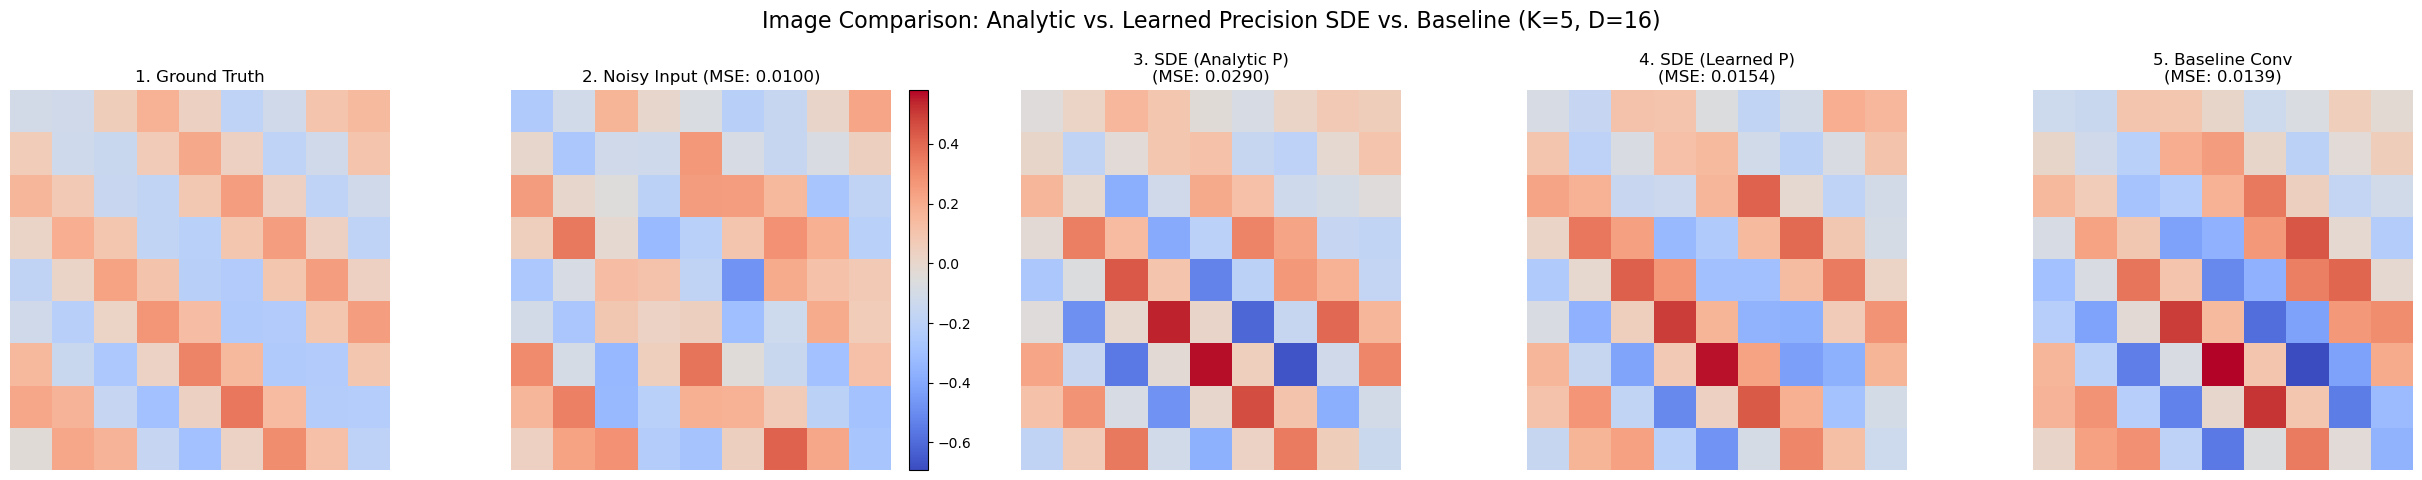

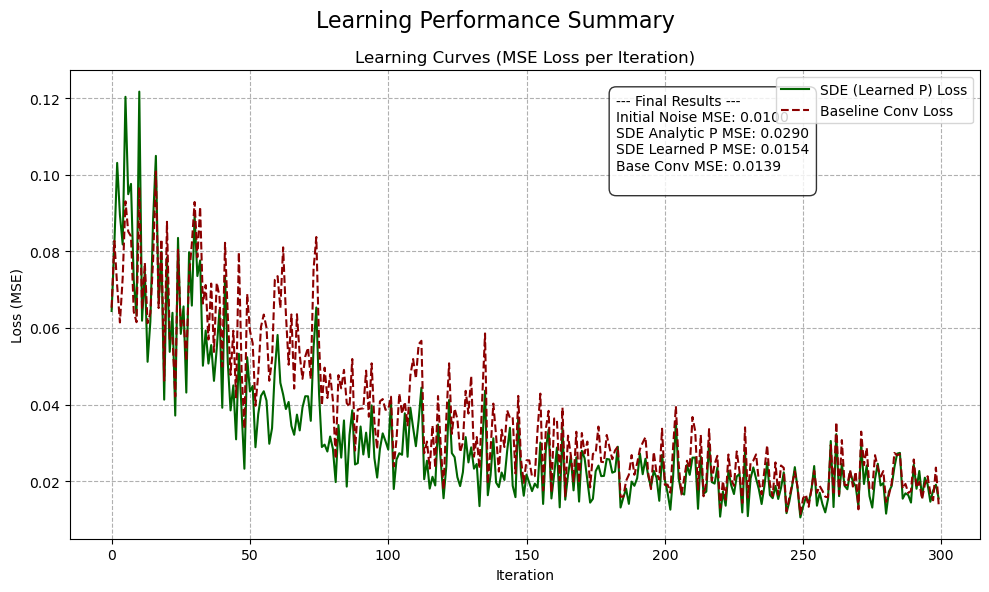

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. Utility Functions ---

def create_sde_ground_truth(H, W, D, alpha_sq, omega_y, center_x, center_y, Z_seed_r):
    """
    Generates the ground-truth feature map (X_gt) based on SDE propagation from a given center.
    This function creates the signal only, no noise is added.
    """
    alpha_sq = alpha_sq.view(1, D)
    omega_y = omega_y.view(1, D)
    
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    Delta_X_prime = x_coords - center_x
    Delta_Y_prime = y_coords - center_y
    
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p')
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = (Phi_r * Z_seed_r).unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # Normalize X_gt to max magnitude 1.0
    if X_gt.abs().max() > 1e-6:
        X_gt = X_gt / X_gt.abs().max()
    
    return X_gt

def add_measurement_noise(X_gt, noise_scale):
    """Adds fresh measurement noise to the ground truth signal."""
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    return X_noisy


# --- 2. SDE Convolution Helper Classes (Base and Projections) ---

class RealToComplexLinear(nn.Module):
    """ X -> Z = X W_r + i X W_i + (b_r + i b_i). (Real -> Complex) """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.b_r = nn.Parameter(torch.zeros(d_model))
        self.b_i = nn.Parameter(torch.zeros(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Z_r = (X @ self.W_r) + self.b_r
        Z_i = (X @ self.W_i) + self.b_i
        return torch.stack([Z_r, Z_i], dim=0) # (2, ..., D)

class ComplexToRealLinear(nn.Module):
    """ Y = Re(Z^+ W_r^T) - Im(Z^+ W_i^T) + c_r. (Complex -> Real) """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.c_r = nn.Parameter(torch.zeros(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (N_patch, D)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T) + self.c_r
        return Y # (N_patch, D)

class SpatialCoordinateTransformer(nn.Module):
    """Generates relative positions Delta p for all pixels relative to the anchor."""
    def __init__(self):
        super().__init__()

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        y_coords_b, x_coords_b = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords_b.float(), y_coords_b.float()], dim=-1) 
        
        y_coords_a, x_coords_a = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords_a.float(), y_coords_a.float()], dim=-1) 

        p_b_flat = p_b.reshape(-1, 2)
        p_a_flat = p_a.reshape(-1, 2)

        anchor_idx = K * K // 2
        p_anchor = p_a_flat[anchor_idx].unsqueeze(0) 
        
        Delta_P = p_anchor - p_b_flat # Displacement from neighbor b to anchor a
        
        return Delta_P # (N_pixels, 2)

# --- 3. Base SDE Convolution Kernel (Abstract Logic) ---

class SDEConvolutionBase(nn.Module):
    """
    Base class containing common SDE propagation and complex number logic.
    Subclasses must implement the precision generation step.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2
        
        # 1. Real-to-Complex Q, K, V Projections
        self.query_projection = RealToComplexLinear(d_model)
        self.key_projection = RealToComplexLinear(d_model)
        self.value_projection = RealToComplexLinear(d_model)
        
        # 2. Complex-to-Real Layer
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 3. Spatial Coordinate Transformer
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 4. SDE Transition Parameters (Shared Learned Dynamics)
        self.raw_alpha_h = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_v = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_h = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_v = nn.Parameter(torch.randn(d_model) * 0.1)
        
        # 5. Coordinate Transformation Parameters
        self.T = nn.Parameter(torch.eye(2) * 0.1)
        self.b = nn.Parameter(torch.zeros(2))
    
    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor, omega_x_NND: torch.Tensor, omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """ Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$. """
        delta_x_prime = delta_p_prime[..., 0] # (1, N_pixels)
        delta_y_prime = delta_p_prime[..., 1] # (1, N_pixels)
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) 
        
        # 1. Decay Term
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1)))
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y 

        # 2. Phase Term
        theta_xy = (omega_x_NND * delta_x_prime.unsqueeze(-1)) + \
                   (omega_y_NND * delta_y_prime.unsqueeze(-1))

        Phi_r = decay_total * torch.cos(theta_xy)
        Phi_i = decay_total * -torch.sin(theta_xy)
        
        # Broadcast Phi across the N_patch dimension (M)
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            Phi_r_final = Phi_r.repeat(1, 1, M)
            Phi_i_final = Phi_i.repeat(1, 1, M)
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        Phi_r_final = Phi_r_final.squeeze(0)
        Phi_i_final = Phi_i_final.squeeze(0)
        
        # 3. Apply the Transition (Complex Dot Product)
        z_hat_r = (Phi_r_final * z_sb_r) - (Phi_i_final * z_sb_i)
        z_hat_i = (Phi_r_final * z_sb_i) + (Phi_i_final * z_sb_r)
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) 

    @staticmethod
    def _quadrant_transition_fn(delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_sq_params: dict, omega_params: dict) -> torch.Tensor:
        """ Applies SDE state transition, handling quadrant selection. """
        D = omega_params['l'].shape[0]
        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]
        
        # Compute Indicator Masks (1, N_pixels, 1)
        mask_x_l_r = (delta_x_prime > 1e-6).float().unsqueeze(-1)
        mask_x_r_r = (delta_x_prime < -1e-6).float().unsqueeze(-1)
        mask_y_b_r = (delta_y_prime > 1e-6).float().unsqueeze(-1)
        mask_y_t_r = (delta_y_prime < -1e-6).float().unsqueeze(-1)
        is_center = ((delta_x_prime.abs() < 1e-6) & (delta_y_prime.abs() < 1e-6)).float().unsqueeze(-1)
        
        get_b = lambda p: p.view(1, 1, D)

        # Compute Spatially-Varying Alpha^2 (1, N_pixels, D)
        alpha_x_sq_NND = (mask_x_l_r * get_b(alpha_sq_params['l'])) + (mask_x_r_r * get_b(alpha_sq_params['r'])) + (is_center * get_b(alpha_sq_params['l']))
        alpha_y_sq_NND = (mask_y_b_r * get_b(alpha_sq_params['b'])) + (mask_y_t_r * get_b(alpha_sq_params['t'])) + (is_center * get_b(alpha_sq_params['b']))
        
        # Compute Spatially-Varying Omega (1, N_pixels, D)
        omega_x_NND = (mask_x_l_r * get_b(omega_params['l'])) + (mask_x_r_r * get_b(omega_params['r'])) + (is_center * get_b(omega_params['l']))
        omega_y_NND = (mask_y_b_r * get_b(omega_params['b'])) + (mask_y_t_r * get_b(omega_params['t'])) + (is_center * get_b(omega_params['b']))
        
        return SDEConvolutionBase._core_transition_fn(
            delta_p_prime, z_sb, alpha_x_sq_NND, alpha_y_sq_NND, omega_x_NND, omega_y_NND,
        )

    def _get_sde_params(self):
        # Use squaring for positivity: alpha^2 = (raw_alpha)^2
        alpha_sq_params = {
            'l': self.raw_alpha_h ** 2, 'r': self.raw_alpha_h ** 2,
            'b': self.raw_alpha_v ** 2, 't': self.raw_alpha_v ** 2
        }
        omega_params = {
            'l': self.omega_h, 'r': self.omega_h,
            'b': self.omega_v, 't': self.omega_v
        }
        return alpha_sq_params, omega_params

    def _get_mahalanobis_components(self, r_sq: torch.Tensor, delta_p: torch.Tensor, alpha_sq_params: dict):
        """ Abstract method: Must be implemented by subclasses to return P_matrix (precision) and D_mah (Mahalanobis distance). """
        raise NotImplementedError("Subclasses must implement _get_mahalanobis_components.")

    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size
        
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)

        # 1. Real -> Complex Q, K, V Projections
        Z_q_flat = self.query_projection(X_flat_reshaped) 
        Z_k_flat = self.key_projection(X_flat_reshaped)   
        Z_v_flat = self.value_projection(X_flat_reshaped) 

        Z_q_batch = Z_q_flat.view(2, N_patch, N_pixels, D)
        Z_k_batch = Z_k_flat.view(2, N_patch, N_pixels, D)
        Z_v_batch = Z_v_flat.view(2, N_patch, N_pixels, D)
        
        Z_q_anchor = Z_q_batch[:, :, self.anchor_idx, :].unsqueeze(2) 
        
        # 2. Coordinate Transform
        Delta_P_prime_raw = self.coord_transformer(K, K) 
        Delta_P_transformed = (Delta_P_prime_raw @ self.T) + self.b
        Delta_P_prime_N_pixels = Delta_P_transformed
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # Mask for valid pixels (not padding zeros)
        X_abs_sum = X_batch_patches.abs().sum(dim=-1, keepdim=True)
        is_data_pixel = (X_abs_sum > 1e-6).float()

        # 3. SDE Transition (Propagation to Anchor for K and V)
        Delta_P_prime_single_anchor = Delta_P_prime_N_pixels.unsqueeze(0)
        
        Z_k_patch_pixels = Z_k_batch.permute(0, 2, 1, 3).contiguous().view(2, N_pixels, N_patch * D)
        Z_v_patch_pixels = Z_v_batch.permute(0, 2, 1, 3).contiguous().view(2, N_pixels, N_patch * D)

        Z_hat_k_raw = self._quadrant_transition_fn(Delta_P_prime_single_anchor, Z_k_patch_pixels, alpha_sq_params, omega_params)
        Z_hat_v_raw = self._quadrant_transition_fn(Delta_P_prime_single_anchor, Z_v_patch_pixels, alpha_sq_params, omega_params)
        
#         Z_hat_k_raw = Z_k_patch_pixels
#         Z_hat_v_raw = Z_v_patch_pixels
        
        Z_hat_k = Z_hat_k_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3)
        Z_hat_v = Z_hat_v_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3)
        
        # 4. Residual and Precision Fusion (Subclass handles this)
        
        # 4a. Residual: $\mathbf{r} = \mathbf{z}_{\mathbf{q}} - \mathbf{\hat{z}}_{\mathbf{k}}$
        residual = Z_q_anchor - Z_hat_k
        r_r, r_i = torch.unbind(residual, dim=0) 
        r_sq = r_r.pow(2) + r_i.pow(2) # (N_patch, N_pixels, D)
        
        # 4b. Get Precision and Mahalanobis Distance (P_matrix is (1, N_pixels, D))
        P_matrix, D_mah = self._get_mahalanobis_components(r_sq, Delta_P_prime_N_pixels, alpha_sq_params)

        # 4c. Final Fusion Weight: $\mathbf{W}_{\text{add}} = \frac{\mathbf{P}_{\text{matrix}}}{\mathbf{1} + \mathbf{D}_{\text{mah}}}$
        W_add = P_matrix / (1.0 + D_mah) # (N_patch, N_pixels, D)
#         W_add = P_matrix / (1.0 + 0*D_mah) # (N_patch, N_pixels, D)
        
        # 5. Calculate Numerator and Denominator
        W_add_broadcast_num = W_add.unsqueeze(0).repeat(2, 1, 1, 1) # (2, N_patch, N_pixels, D)
        Z_numerator = Z_hat_v * W_add_broadcast_num 
        
        is_data_pixel_broadcast_num = is_data_pixel.unsqueeze(0) 
        Z_hat_weighted_sum = (Z_numerator * is_data_pixel_broadcast_num).sum(dim=2, keepdim=False) # (2, N_patch, D)

        W_add_sum_valid = (W_add * is_data_pixel).sum(dim=1, keepdim=False)
        W_add_sum_valid = torch.clamp(W_add_sum_valid, min=1e-8) # (N_patch, D)

        # 6. Normalize (Weighted Average)
        denominator_broadcast = W_add_sum_valid.unsqueeze(0).repeat(2, 1, 1) 
        Z_hat_weighted_final_norm = Z_hat_weighted_sum / denominator_broadcast
#         Z_hat_weighted_final_norm = Z_hat_weighted_sum
    
        # 7. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted_final_norm)
        
        return Y_anchors 


class SDEAttentionConvolution_AnalyticP(SDEConvolutionBase):
    """
    SDE Kernel using learned SDE noise parameters to analytically calculate 
    the inverse covariance (precision) matrix P. (Original method)
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__(d_model, kernel_size)
        D = d_model
        
        # Learnable Precision weighting constants (D-DIMENSIONAL NOISE PARAMETERS)
        self.raw_sigma_x = nn.Parameter(torch.ones(D) * 1.0)  # Process Noise scale (D-dim)
        self.raw_sigma_y = nn.Parameter(torch.ones(D) * 1.0)
        self.raw_eta = nn.Parameter(torch.ones(D) * 1e-3)     # Measurement Noise scale (D-dim)
        self.raw_gamma = nn.Parameter(torch.ones(D) * 1e-3)   # Stabilization term (D-dim)
        self.COV_EPSILON = 1e-8

    def _compute_propagation_variance(self, delta_p_prime: torch.Tensor, alpha_sq_params: dict) -> torch.Tensor:
        """ Computes the FEATURE-WISE total variance ($\sigma_V^2$) (N_pixels, D) based on SDE solution. """
        D = self.d_model
        
        # Get D-dim noise parameters (reshaped for broadcast (1, D))
        sigma_x = F.softplus(self.raw_sigma_x).view(1, D) 
        sigma_y = F.softplus(self.raw_sigma_y).view(1, D)
        eta = F.softplus(self.raw_eta).view(1, D)
        gamma = F.softplus(self.raw_gamma).view(1, D)
        
        dx = torch.abs(delta_p_prime[..., 0]).unsqueeze(-1) # $\Delta x'$ (N_pixels, 1)
        dy = torch.abs(delta_p_prime[..., 1]).unsqueeze(-1) # $\Delta y'$ (N_pixels, 1)

        alpha_x_sq_D = alpha_sq_params['l'].view(1, D) # (1, D)
        alpha_y_sq_D = alpha_sq_params['b'].view(1, D) # (1, D)

        denom_x_D = -2 * alpha_x_sq_D # (1, D)
        denom_y_D = -2 * alpha_y_sq_D # (1, D)
        ALPHA_EPSILON = 1e-6
        
        # Variance term for the x-axis SDE (OU Process DLE solution)
        sigma_x_sq_term = torch.where(
            torch.abs(denom_x_D) < ALPHA_EPSILON,
            sigma_x**2 * dx, 
            sigma_x**2 * (torch.exp(denom_x_D * dx) - 1) / denom_x_D
        )

        # Variance term for the y-axis SDE
        sigma_y_sq_term = torch.where(
            torch.abs(denom_y_D) < ALPHA_EPSILON,
            sigma_y**2 * dy, 
            sigma_y**2 * (torch.exp(denom_y_D * dy) - 1) / denom_y_D
        )
        
        # Total Variance: (Process Var_x * Process Var_y) + (Measurement Var + Stabilization)
        cross_term = eta**2 * torch.exp(denom_x_D * dx + denom_y_D * dy) + gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term + self.COV_EPSILON # (N_pixels, D)
        
        return sigma_V_sq 

    def _get_mahalanobis_components(self, r_sq: torch.Tensor, delta_p: torch.Tensor, alpha_sq_params: dict):
        """ Calculates P and D_mah using analytic variance formula. """
        sigma_V_sq = self._compute_propagation_variance(delta_p, alpha_sq_params) # (N_pixels, D)
        
        # Analytic Precision $\mathbf{P}_{\text{analyt}} = 1 / \sigma_V^2$
        sigma_V_sq_broadcast = sigma_V_sq.unsqueeze(0) # (1, N_pixels, D)
        P_matrix = 1.0 / sigma_V_sq_broadcast 

        # Mahalanobis Distance D_mah
        D_mah = (r_sq * P_matrix).sum(dim=-1, keepdim=True) 
        
        return P_matrix, D_mah


class SDEAttentionConvolution_LearnedP(SDEConvolutionBase):
    """
    SDE Kernel using a fully learned, depthwise-separated parameter 
    for the precision matrix P.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__(d_model, kernel_size)
        
        # Learned Precision Parameter (D-dimensional, spatial K*K-dimensional)
        self.raw_precision_weights = nn.Parameter(torch.ones(d_model, self.num_pixels) * 0.1)

    def _get_mahalanobis_components(self, r_sq: torch.Tensor, delta_p: torch.Tensor, alpha_sq_params: dict):
        """ Calculates P and D_mah using a learned precision matrix. """
        
        # Learned Precision $\mathbf{P}_{\text{learned}} = \text{softplus}(\mathbf{W}_P^T)$
        P_raw = self.raw_precision_weights**2 # (D, N_pixels)
        P_learned = P_raw.T                            # (N_pixels, D)
        P_matrix = P_learned.unsqueeze(0)              # (1, N_pixels, D)

        # Mahalanobis Distance D_mah
        D_mah = (r_sq * P_matrix).sum(dim=-1, keepdim=True) 
        
        return P_matrix, D_mah


# --- 4. Full Convolution Wrapper Classes ---

class SDEConv2dWrapper(nn.Module):
    """ Wrapper that implements the full 2D sliding-window operation for any SDE Kernel. """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None, sde_kernel=None):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = kernel_size // 2 if padding is None else padding
        self.sde_kernel = sde_kernel
        if sde_kernel is None:
             raise ValueError("SDEConv2dWrapper requires a valid SDE kernel instance.")


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        B, D, H, W = X.shape
        K, S = self.kernel_size, self.stride
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        N_patches = patches_unfolded.shape[2]
        
        # 2. Reshape for SDE Kernel: (B * N_patches, N_pixels, D)
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)
        
        # 4. Reshape and Reassemble: (B, D, H_out, W_out)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

class BaselineConv2d(nn.Module):
    """ Standard CNN architecture matching the complexity of the SDE Attention Conv. """
    # Renamed 'a' to 'expansion_factor' as requested.
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, expansion_factor: int = 1, padding: int = None):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        
        # 1. D -> (expansion_factor * D) mapping (Expansion via 1x1 Conv)
        self.conv_in = nn.Conv2d(d_model, expansion_factor * d_model, kernel_size=1) 
        
        # 2. KxK Convolution (Depthwise)
        # FIX: The in_channels, out_channels, and groups must all match (expansion_factor * d_model)
        intermediate_channels = expansion_factor * d_model
        self.conv_core = nn.Conv2d(
            in_channels=intermediate_channels,  
            out_channels=intermediate_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding,
            groups=intermediate_channels 
        )
        
        # 3. (expansion_factor * D) -> D mapping (Reduction via 1x1 Conv)
        self.conv_out = nn.Conv2d(intermediate_channels, d_model, kernel_size=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv_in(X)
        X = self.conv_core(X)
        Y = self.conv_out(X)
        return Y

# --- 5. Training and Comparison Function ---

def train_and_compare_models(H=15, W=15, D=9, K=9, S=1, epochs=300, lr=1e-3, noise_scale=0.1):
    """Trains and compares three models: Baseline, SDE (Analytic P), and SDE (Learned P)."""
    print(f"--- Model Comparison (K={K}, D={D}, Epochs={epochs}, Dynamic Noise={noise_scale}) ---")
    
    # --- 1. Model Initialization ---
    # SDE (Analytic P)
    analytic_kernel = SDEAttentionConvolution_AnalyticP(d_model=D, kernel_size=K)
    analytic_model = SDEConv2dWrapper(d_model=D, kernel_size=K, stride=S, sde_kernel=analytic_kernel)
    
    # SDE (Learned P)
    learned_kernel = SDEAttentionConvolution_LearnedP(d_model=D, kernel_size=K)
    learned_model = SDEConv2dWrapper(d_model=D, kernel_size=K, stride=S, sde_kernel=learned_kernel)
    
    # Baseline
    # Pass expansion_factor=2 to match the SDE model's D -> 2*D complex expansion (Real/Imag)
    baseline_model = BaselineConv2d(d_model=D, kernel_size=K, stride=S, expansion_factor=1)

    # Count parameters
    def count_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    sde_analytic_params = count_params(analytic_model)
    sde_learned_params = count_params(learned_model)
    base_params = count_params(baseline_model)
    
    print(f"SDE Analytic P Parameters: {sde_analytic_params}")
    print(f"SDE Learned P Parameters: {sde_learned_params}")
    print(f"Baseline Conv Parameters: {base_params}")
    
    # --- 2. Training Setup ---
    criterion = nn.MSELoss()
    analytic_optimizer = torch.optim.Adam(analytic_model.parameters(), lr=lr)
    learned_optimizer = torch.optim.Adam(learned_model.parameters(), lr=lr)
    baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)
    
    # List of models and optimizers for clipping
    models = [analytic_model, learned_model, baseline_model]
    optimizers = [analytic_optimizer, learned_optimizer, baseline_optimizer]

    analytic_losses = []
    learned_losses = []
    baseline_losses = []
    
    X_gt = None
    X_noisy = None
    ALPHA_SQ_GEN = torch.abs(torch.randn(D) * 0.1) + 0.05 
    OMEGA_GEN = torch.randn(D) * (math.pi / 4.0)          

    # --- 3. Training Loop ---
    for epoch in tqdm(range(epochs), desc="Training"):
        # Dynamic Data Generation
        center_x = torch.rand(1).item() * (W - 1)
        center_y = torch.rand(1).item() * (H - 1)
        Z_seed_r = torch.randn(1, D) * 3.0 + 5.0
        X_gt_iter = create_sde_ground_truth(H, W, D, ALPHA_SQ_GEN, OMEGA_GEN, center_x, center_y, Z_seed_r)
        X_noisy_iter = add_measurement_noise(X_gt_iter, noise_scale)
        X_gt = X_gt_iter
        X_noisy = X_noisy_iter

        # Train Analytic Model
        analytic_optimizer.zero_grad()
        analytic_output = analytic_model(X_noisy_iter)
        analytic_loss = criterion(analytic_output, X_gt_iter)
        analytic_loss.backward()
        torch.nn.utils.clip_grad_norm_(analytic_model.parameters(), max_norm=1.0) # CLIPPING ADDED HERE
        analytic_optimizer.step()
        analytic_losses.append(analytic_loss.item())
        
        # Train Learned Model
        learned_optimizer.zero_grad()
        learned_output = learned_model(X_noisy_iter)
        learned_loss = criterion(learned_output, X_gt_iter)
        learned_loss.backward()
        torch.nn.utils.clip_grad_norm_(learned_model.parameters(), max_norm=1.0) # CLIPPING ADDED HERE
        learned_optimizer.step()
        learned_losses.append(learned_loss.item())

        # Train Baseline Model
        baseline_optimizer.zero_grad()
        baseline_output = baseline_model(X_noisy_iter)
        baseline_loss = criterion(baseline_output, X_gt_iter)
        baseline_loss.backward()
        torch.nn.utils.clip_grad_norm_(baseline_model.parameters(), max_norm=1.0) # CLIPPING ADDED HERE
        baseline_optimizer.step()
        baseline_losses.append(baseline_loss.item())
        
        if (epoch + 1) % 100 == 0 or epoch == epochs - 1:
            print(f"Iter {epoch + 1}/{epochs}: Analytic Loss={analytic_loss.item():.6f}, Learned Loss={learned_loss.item():.6f}, Baseline Loss={baseline_loss.item():.6f}")

    # --- 4. Final Evaluation ---
    analytic_model.eval()
    learned_model.eval()
    baseline_model.eval()
    with torch.no_grad():
        analytic_output_final = analytic_model(X_noisy)
        learned_output_final = learned_model(X_noisy)
        baseline_output_final = baseline_model(X_noisy)
    analytic_model.train()
    learned_model.train()
    baseline_model.train()
    
    mse_noisy = criterion(X_noisy, X_gt).item()
    mse_analytic = criterion(analytic_output_final, X_gt).item()
    mse_learned = criterion(learned_output_final, X_gt).item()
    mse_baseline = criterion(baseline_output_final, X_gt).item()
    
    print("\n--- Final Evaluation ---")
    print(f"Initial Noise MSE: {mse_noisy:.6f}")
    print(f"SDE (Analytic P) Final MSE: {mse_analytic:.6f} (Reduction: {mse_noisy/mse_analytic:.2f}x)")
    print(f"SDE (Learned P) Final MSE: {mse_learned:.6f} (Reduction: {mse_noisy/mse_learned:.2f}x)")
    print(f"Baseline Conv Final MSE: {mse_baseline:.6f} (Reduction: {mse_noisy/mse_baseline:.2f}x)")
    
    # --- 5. Visualization ---
    
    def plot_final_image(ax, img_data, title, vmin, vmax, colorbar=False):
        im = ax.imshow(img_data, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        if colorbar:
            fig1.colorbar(im, ax=ax, fraction=0.046, pad=0.04) 
        return im

    # Get data for Feature 0
    img_gt = X_gt[0, 0, :, :].detach().cpu().numpy()
    img_noisy = X_noisy[0, 0, :, :].detach().cpu().numpy()
    img_analytic = analytic_output_final[0, 0, :, :].detach().cpu().numpy()
    img_learned = learned_output_final[0, 0, :, :].detach().cpu().numpy()
    img_baseline = baseline_output_final[0, 0, :, :].detach().cpu().numpy()
    
    # Determine global color range for consistent comparison across all images
    vmin = min(img_gt.min(), img_noisy.min(), img_analytic.min(), img_learned.min(), img_baseline.min())
    vmax = max(img_gt.max(), img_noisy.max(), img_analytic.max(), img_learned.max(), img_baseline.max())

    # --- FIGURE 1: Image Comparison (GT, Noisy, Analytic, Learned, Baseline) ---
    fig1, axes1 = plt.subplots(1, 5, figsize=(25, 5)) 

    plot_final_image(axes1[0], img_gt, '1. Ground Truth', vmin, vmax)
    plot_final_image(axes1[1], img_noisy, f'2. Noisy Input (MSE: {mse_noisy:.4f})', vmin, vmax, colorbar=True)
    plot_final_image(axes1[2], img_analytic, f'3. SDE (Analytic P)\n(MSE: {mse_analytic:.4f})', vmin, vmax)
    plot_final_image(axes1[3], img_learned, f'4. SDE (Learned P)\n(MSE: {mse_learned:.4f})', vmin, vmax)
    plot_final_image(axes1[4], img_baseline, f'5. Baseline Conv\n(MSE: {mse_baseline:.4f})', vmin, vmax)

    fig1.suptitle(f"Image Comparison: Analytic vs. Learned Precision SDE vs. Baseline (K={K}, D={D})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # --- FIGURE 2: Loss Curves and Summary ---
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
#     ax2.plot(analytic_losses, label='SDE (Analytic P) Loss', color='darkblue')
    ax2.plot(learned_losses, label='SDE (Learned P) Loss', color='darkgreen')
    ax2.plot(baseline_losses, label='Baseline Conv Loss', color='darkred', linestyle='--')
    ax2.set_title('Learning Curves (MSE Loss per Iteration)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss (MSE)')
    ax2.legend()
    ax2.grid(True, which="both", ls="--")
    
    # Add text comparison table to the loss plot figure
    table_text = (
        f"--- Final Results ---\n"
        f"Initial Noise MSE: {mse_noisy:.4f}\n"
        f"SDE Analytic P MSE: {mse_analytic:.4f}\n"
        f"SDE Learned P MSE: {mse_learned:.4f}\n"
        f"Base Conv MSE: {mse_baseline:.4f}\n"
    )
    ax2.text(0.6, 0.95, table_text, transform=ax2.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    fig2.suptitle(f"Learning Performance Summary", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == '__main__':
    # Run the training and comparison
    # H=15, W=15, D=9, K=9, epochs=300 -> Changed to 500 for better stability testing
    train_and_compare_models(H=9, W=9, D=16, K=5, epochs=300, lr=1e-3, noise_scale=0.1)


--- Global Setup: Device is CUDA ---
Files already downloaded and verified
Files already downloaded and verified
--- Data Loading Complete. ---
--- Running Comparison on CUDA (K=7, D=8, Epochs=3, Noise=0.2) ---
SDE Analytic P Parameters: 697
SDE Learned P Parameters: 1057
Baseline Conv Parameters: 1139


Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████| 782/782 [01:51<00:00,  7.02it/s]


Epoch 1 finished (782 iterations).


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████| 782/782 [01:47<00:00,  7.28it/s]


Epoch 2 finished (782 iterations).


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████| 782/782 [01:47<00:00,  7.29it/s]


Epoch 3 finished (782 iterations).

--- Final Evaluation ---
Initial Noise MSE: 0.039893
SDE (Analytic P) Final MSE: 0.010641 (vs Noise: 3.75x)
SDE (Learned P) Final MSE: 0.007419 (vs Noise: 5.38x)
Baseline Conv Final MSE: 0.009022 (vs Noise: 4.42x)


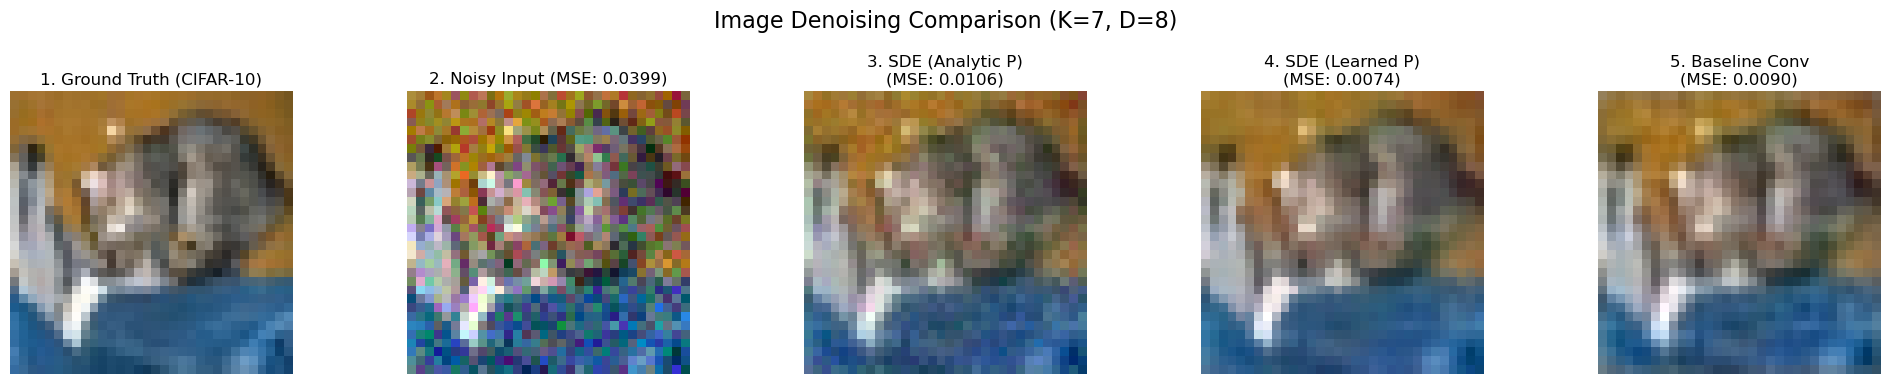

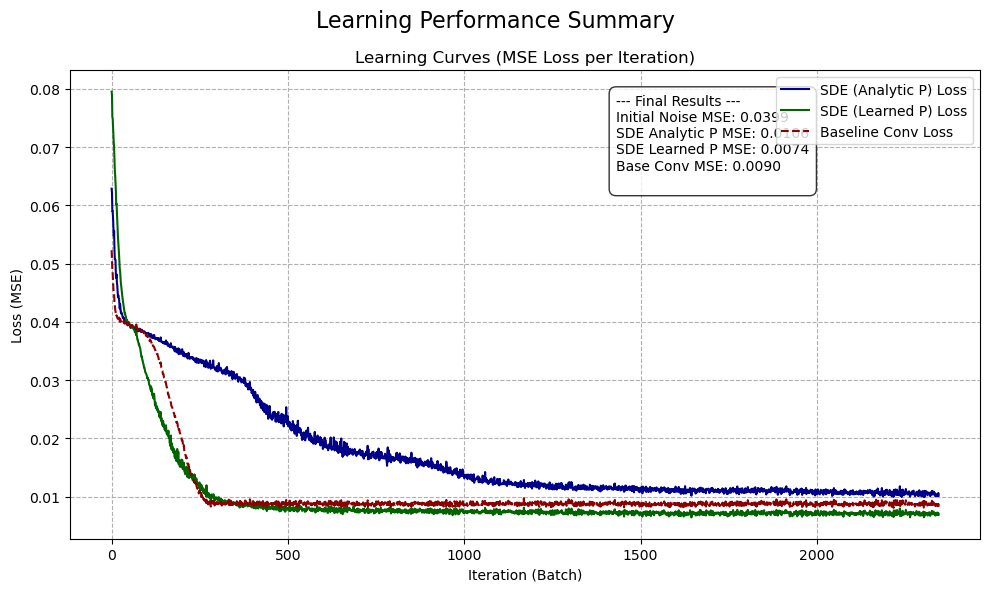

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# --- 1. Data Loading Function ---

def load_cifar_data(batch_size=32):
    """Loads and preprocesses CIFAR-10 data."""
    # Define transformations: Convert to tensor and normalize (standard for CIFAR)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Download and load the training dataset
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    # Download and load the test dataset for final visualization
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

# --- 2. Synthetic Data Functions (Kept for context but not used in the main training loop) ---
def create_sde_ground_truth(H, W, D, alpha_sq, omega_y, center_x, center_y, Z_seed_r):
    """Generates the ground-truth feature map (X_gt) based on SDE propagation from a given center."""
    return torch.zeros(1, D, H, W) 

def add_measurement_noise(X_gt, noise_scale):
    """Adds fresh measurement noise to the ground truth signal."""
    return X_gt 


# --- 3. SDE Convolution Helper Classes (Base and Projections) ---

class RealToComplexLinear(nn.Module):
    """ X -> Z = X W_r + i X W_i + (b_r + i b_i). (Real -> Complex) """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Initialize W_r, W_i using Kaiming/Xavier initialization scaled for complex
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.b_r = nn.Parameter(torch.zeros(d_model))
        self.b_i = nn.Parameter(torch.zeros(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Z_r = (X @ self.W_r) + self.b_r
        Z_i = (X @ self.W_i) + self.b_i
        return torch.stack([Z_r, Z_i], dim=0) # (2, ..., D)

class ComplexToRealLinear(nn.Module):
    """ Y = Re(Z^+ W_r^T) - Im(Z^+ W_i^T) + c_r. (Complex -> Real) """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.c_r = nn.Parameter(torch.zeros(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (N_patch, D)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T) + self.c_r
        return Y # (N_patch, D)

class SpatialCoordinateTransformer(nn.Module):
    """Generates relative positions Delta p for all pixels relative to the anchor."""
    def __init__(self):
        super().__init__()

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        # NOTE: Tensors created here are on CPU by default
        y_coords_b, x_coords_b = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords_b.float(), y_coords_b.float()], dim=-1) 
        
        y_coords_a, x_coords_a = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords_a.float(), y_coords_a.float()], dim=-1) 

        p_b_flat = p_b.reshape(-1, 2)
        p_a_flat = p_a.reshape(-1, 2)

        anchor_idx = K * K // 2
        p_anchor = p_a_flat[anchor_idx].unsqueeze(0) 
        
        # Displacement from neighbor b to anchor a: p_a - p_b (Anchor is always in the center of the patch)
        Delta_P = p_b_flat - p_anchor 
        
        return Delta_P # (N_pixels, 2)

# --- 4. Base SDE Convolution Kernel (Abstract Logic) ---

class SDEConvolutionBase(nn.Module):
    """
    Base class containing common SDE propagation and complex number logic.
    Subclasses must implement the precision generation step.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2
        
        # 1. Real-to-Complex Q, K, V Projections
        self.query_projection = RealToComplexLinear(d_model)
        self.key_projection = RealToComplexLinear(d_model)
        self.value_projection = RealToComplexLinear(d_model)
        
        # 2. Complex-to-Real Layer
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 3. Spatial Coordinate Transformer
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 4. SDE Transition Parameters (Shared Learned Dynamics)
        self.raw_alpha_h = nn.Parameter(torch.randn(d_model) * 0.1)
        self.raw_alpha_v = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_h = nn.Parameter(torch.randn(d_model) * 0.1)
        self.omega_v = nn.Parameter(torch.randn(d_model) * 0.1)
        
        # 5. Coordinate Transformation Parameters (Learned affine map)
        self.T = nn.Parameter(torch.eye(2) * 0.1)
        self.b = nn.Parameter(torch.zeros(2))
    
    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor, omega_x_NND: torch.Tensor, omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """ Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$. """
        delta_x_prime = delta_p_prime[..., 0] # (1, N_pixels)
        delta_y_prime = delta_p_prime[..., 1] # (1, N_pixels)
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) 
        
        # 1. Decay Term
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1)))
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y 

        # 2. Phase Term
        theta_xy = (omega_x_NND * delta_x_prime.unsqueeze(-1)) + \
                   (omega_y_NND * delta_y_prime.unsqueeze(-1))

        Phi_r = decay_total * torch.cos(theta_xy)
        Phi_i = decay_total * -torch.sin(theta_xy)
        
        # Broadcast Phi across the N_patch dimension (M)
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            Phi_r_final = Phi_r.repeat(1, 1, M)
            Phi_i_final = Phi_i.repeat(1, 1, M)
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        Phi_r_final = Phi_r_final.squeeze(0)
        Phi_i_final = Phi_i_final.squeeze(0)
        
        # 3. Apply the Transition (Complex Dot Product)
        z_hat_r = (Phi_r_final * z_sb_r) - (Phi_i_final * z_sb_i)
        z_hat_i = (Phi_r_final * z_sb_i) + (Phi_i_final * z_sb_r)
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) 

    @staticmethod
    def _quadrant_transition_fn(delta_p_prime: torch.Tensor, z_sb: torch.Tensor, alpha_sq_params: dict, omega_params: dict) -> torch.Tensor:
        """ Applies SDE state transition, handling quadrant selection. """
        D = omega_params['l'].shape[0]
        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]
        
        # Compute Indicator Masks (1, N_pixels, 1)
        mask_x_l_r = (delta_x_prime > 1e-6).float().unsqueeze(-1)
        mask_x_r_r = (delta_x_prime < -1e-6).float().unsqueeze(-1)
        mask_y_b_r = (delta_y_prime > 1e-6).float().unsqueeze(-1)
        mask_y_t_r = (delta_y_prime < -1e-6).float().unsqueeze(-1)
        is_center = ((delta_x_prime.abs() < 1e-6) & (delta_y_prime.abs() < 1e-6)).float().unsqueeze(-1)
        
        get_b = lambda p: p.view(1, 1, D)

        # Spatially-Varying Alpha^2 (1, N_pixels, D)
        alpha_x_sq_NND = (mask_x_l_r * get_b(alpha_sq_params['l'])) + (mask_x_r_r * get_b(alpha_sq_params['r'])) + (is_center * get_b(alpha_sq_params['l']))
        alpha_y_sq_NND = (mask_y_b_r * get_b(alpha_sq_params['b'])) + (mask_y_t_r * get_b(alpha_sq_params['t'])) + (is_center * get_b(alpha_sq_params['b']))
        
        # Spatially-Varying Omega (1, N_pixels, D)
        omega_x_NND = (mask_x_l_r * get_b(omega_params['l'])) + (mask_x_r_r * get_b(omega_params['r'])) + (is_center * get_b(omega_params['l']))
        omega_y_NND = (mask_y_b_r * get_b(omega_params['b'])) + (mask_y_t_r * get_b(omega_params['t'])) + (is_center * get_b(omega_params['b']))
        
        return SDEConvolutionBase._core_transition_fn(
            delta_p_prime, z_sb, alpha_x_sq_NND, alpha_y_sq_NND, omega_x_NND, omega_y_NND,
        )

    def _get_sde_params(self):
        # FIX: Apply a Sigmoid and scale to ensure alpha^2 remains in a stable, non-zero range
        # This prevents numerical instability in the Analytic P model's variance formula.
        alpha_h_stable = torch.sigmoid(self.raw_alpha_h) * 5.0 + 0.05
        alpha_v_stable = torch.sigmoid(self.raw_alpha_v) * 5.0 + 0.05
        
        alpha_sq_params = {
            # Use stable alphas squared for the decay rate alpha^2
            'l': alpha_h_stable ** 2, 'r': alpha_h_stable ** 2,
            'b': alpha_v_stable ** 2, 't': alpha_v_stable ** 2
        }
        omega_params = {
            'l': self.omega_h, 'r': self.omega_h,
            'b': self.omega_v, 't': self.omega_v
        }
        return alpha_sq_params, omega_params

    def _get_mahalanobis_components(self, r_sq: torch.Tensor, delta_p: torch.Tensor, alpha_sq_params: dict):
        """ Abstract method: Must be implemented by subclasses to return P_matrix (precision) and D_mah (Mahalanobis distance). """
        raise NotImplementedError("Subclasses must implement _get_mahalanobis_components.")

    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size
        
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)

        # 1. Real -> Complex Q, K, V Projections
        Z_q_flat = self.query_projection(X_flat_reshaped) 
        Z_k_flat = self.key_projection(X_flat_reshaped)   
        Z_v_flat = self.value_projection(X_flat_reshaped) 

        Z_q_batch = Z_q_flat.view(2, N_patch, N_pixels, D)
        Z_k_batch = Z_k_flat.view(2, N_patch, N_pixels, D)
        Z_v_batch = Z_v_flat.view(2, N_patch, N_pixels, D)
        
        Z_q_anchor = Z_q_batch[:, :, self.anchor_idx, :].unsqueeze(2) 
        
        # 2. Coordinate Transform
        Delta_P_prime_raw = self.coord_transformer(K, K) 
        
        # FIX: Move the CPU-created coordinate tensor to the model's device (e.g., CUDA)
        device = self.T.device
        Delta_P_prime_raw = Delta_P_prime_raw.to(device)
        
        Delta_P_transformed = (Delta_P_prime_raw @ self.T) + self.b
        Delta_P_prime_N_pixels = Delta_P_transformed
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # Mask for valid pixels (not padding zeros)
        X_abs_sum = X_batch_patches.abs().sum(dim=-1, keepdim=True)
        is_data_pixel = (X_abs_sum > 1e-6).float()

        # 3. SDE Transition (Propagation to Anchor for K and V)
        Delta_P_prime_single_anchor = Delta_P_prime_N_pixels.unsqueeze(0)
        
        Z_k_patch_pixels = Z_k_batch.permute(0, 2, 1, 3).contiguous().view(2, N_pixels, N_patch * D)
        Z_v_patch_pixels = Z_v_batch.permute(0, 2, 1, 3).contiguous().view(2, N_pixels, N_patch * D)

        Z_hat_k_raw = self._quadrant_transition_fn(Delta_P_prime_single_anchor, Z_k_patch_pixels, alpha_sq_params, omega_params)
        Z_hat_v_raw = self._quadrant_transition_fn(Delta_P_prime_single_anchor, Z_v_patch_pixels, alpha_sq_params, omega_params)
        
        Z_hat_k = Z_hat_k_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3)
        Z_hat_v = Z_hat_v_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3)
        
        # 4. Residual and Precision Fusion (Subclass handles this)
        
        # 4a. Residual: $\mathbf{r} = \mathbf{z}_{\mathbf{q}} - \mathbf{\hat{z}}_{\mathbf{k}}$
        residual = Z_q_anchor - Z_hat_k
        r_r, r_i = torch.unbind(residual, dim=0) 
        r_sq = r_r.pow(2) + r_i.pow(2) # (N_patch, N_pixels, D)
        
        # 4b. Get Precision and Mahalanobis Distance (P_matrix is (1, N_pixels, D))
        P_matrix, D_mah = self._get_mahalanobis_components(r_sq, Delta_P_prime_N_pixels, alpha_sq_params)

        # 4c. Final Fusion Weight: $\mathbf{W}_{\text{add}} = \frac{\mathbf{P}_{\text{matrix}}}{\mathbf{1} + \mathbf{D}_{\text{mah}}}$
        W_add = P_matrix / (1.0 + D_mah) # (N_patch, N_pixels, D)
        
        # 5. Calculate Numerator and Denominator
        W_add_broadcast_num = W_add.unsqueeze(0).repeat(2, 1, 1, 1) # (2, N_patch, N_pixels, D)
        Z_numerator = Z_hat_v * W_add_broadcast_num 
        
        is_data_pixel_broadcast_num = is_data_pixel.unsqueeze(0) 
        Z_hat_weighted_sum = (Z_numerator * is_data_pixel_broadcast_num).sum(dim=2, keepdim=False) # (2, N_patch, D)

        W_add_sum_valid = (W_add * is_data_pixel).sum(dim=1, keepdim=False)
        W_add_sum_valid = torch.clamp(W_add_sum_valid, min=1e-8) # (N_patch, D)

        # 6. Normalize (Weighted Average)
        denominator_broadcast = W_add_sum_valid.unsqueeze(0).repeat(2, 1, 1) 
        Z_hat_weighted_final_norm = Z_hat_weighted_sum / denominator_broadcast
    
        # 7. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted_final_norm)
        
        return Y_anchors 


class SDEAttentionConvolution_AnalyticP(SDEConvolutionBase):
    """
    SDE Kernel using learned SDE noise parameters to analytically calculate 
    the inverse covariance (precision) matrix P. (Original method)
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__(d_model, kernel_size)
        D = d_model
        
        # Learnable Precision weighting constants (D-DIMENSIONAL NOISE PARAMETERS)
        self.raw_sigma_x = nn.Parameter(torch.ones(D) * 1.0) # Process Noise scale (D-dim)
        self.raw_sigma_y = nn.Parameter(torch.ones(D) * 1.0)
        self.raw_eta = nn.Parameter(torch.ones(D) * 1e-3)    # Measurement Noise scale (D-dim)
        self.raw_gamma = nn.Parameter(torch.ones(D) * 1e-3)  # Stabilization term (D-dim)
        self.COV_EPSILON = 1e-8

    def _compute_propagation_variance(self, delta_p_prime: torch.Tensor, alpha_sq_params: dict) -> torch.Tensor:
        """ Computes the FEATURE-WISE total variance ($\sigma_V^2$) (N_pixels, D) based on SDE solution. """
        D = self.d_model
        
        # Get D-dim noise parameters (reshaped for broadcast (1, D))
        sigma_x = F.softplus(self.raw_sigma_x).view(1, D) 
        sigma_y = F.softplus(self.raw_sigma_y).view(1, D)
        eta = F.softplus(self.raw_eta).view(1, D)
        gamma = F.softplus(self.raw_gamma).view(1, D)
        
        dx = torch.abs(delta_p_prime[..., 0]).unsqueeze(-1) # $\Delta x'$ (N_pixels, 1)
        dy = torch.abs(delta_p_prime[..., 1]).unsqueeze(-1) # $\Delta y'$ (N_pixels, 1)

        alpha_x_sq_D = alpha_sq_params['l'].view(1, D) # (1, D)
        alpha_y_sq_D = alpha_sq_params['b'].view(1, D) # (1, D)

        denom_x_D = -2 * alpha_x_sq_D # (1, D)
        denom_y_D = -2 * alpha_y_sq_D # (1, D)
        ALPHA_EPSILON = 1e-6
        
        # Variance term for the x-axis SDE (OU Process DLE solution)
        sigma_x_sq_term = torch.where(
            torch.abs(denom_x_D) < ALPHA_EPSILON,
            sigma_x**2 * dx, 
            sigma_x**2 * (torch.exp(denom_x_D * dx) - 1) / denom_x_D
        )

        # Variance term for the y-axis SDE
        sigma_y_sq_term = torch.where(
            torch.abs(denom_y_D) < ALPHA_EPSILON,
            sigma_y**2 * dy, 
            sigma_y**2 * (torch.exp(denom_y_D * dy) - 1) / denom_y_D
        )
        
        # Total Variance: (Process Var_x * Process Var_y) + (Measurement Var + Stabilization)
        cross_term = eta**2 * torch.exp(denom_x_D * dx + denom_y_D * dy) + gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term + self.COV_EPSILON # (N_pixels, D)
        
        return sigma_V_sq 

    def _get_mahalanobis_components(self, r_sq: torch.Tensor, delta_p: torch.Tensor, alpha_sq_params: dict):
        """ Calculates P and D_mah using analytic variance formula. """
        sigma_V_sq = self._compute_propagation_variance(delta_p, alpha_sq_params) # (N_pixels, D)
        
        # Analytic Precision $\mathbf{P}_{\text{analyt}} = 1 / \sigma_V^2$
        sigma_V_sq_broadcast = sigma_V_sq.unsqueeze(0) # (1, N_pixels, D)
        P_matrix = 1.0 / sigma_V_sq_broadcast 

        # Mahalanobis Distance D_mah
        D_mah = (r_sq * P_matrix).sum(dim=-1, keepdim=True) 
        
        return P_matrix, D_mah


class SDEAttentionConvolution_LearnedP(SDEConvolutionBase):
    """
    SDE Kernel using a fully learned, depthwise-separated parameter 
    for the precision matrix P.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__(d_model, kernel_size)
        
        # Learned Precision Parameter (D-dimensional, spatial K*K-dimensional)
        self.raw_precision_weights = nn.Parameter(torch.ones(d_model, self.num_pixels) * 0.1)

    def _get_mahalanobis_components(self, r_sq: torch.Tensor, delta_p: torch.Tensor, alpha_sq_params: dict):
        """ Calculates P and D_mah using a learned precision matrix. """
        
        # Learned Precision $\mathbf{P}_{\text{learned}} = \text{softplus}(\mathbf{W}_P^T)$
        # Using squaring for guaranteed positivity as per base implementation
        P_raw = self.raw_precision_weights**2 # (D, N_pixels)
        P_learned = P_raw.T                    # (N_pixels, D)
        P_matrix = P_learned.unsqueeze(0)      # (1, N_pixels, D)

        # Mahalanobis Distance D_mah
        D_mah = (r_sq * P_matrix).sum(dim=-1, keepdim=True) 
        
        return P_matrix, D_mah


# --- 5. Full Convolution Wrapper Classes ---

class SDEConv2dWrapper(nn.Module):
    """ Wrapper that implements the full 2D sliding-window operation for any SDE Kernel. """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None, sde_kernel=None):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = kernel_size // 2 if padding is None else padding
        self.sde_kernel = sde_kernel
        if sde_kernel is None:
            raise ValueError("SDEConv2dWrapper requires a valid SDE kernel instance.")


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        B, D, H, W = X.shape
        K, S = self.kernel_size, self.stride
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        N_patches = patches_unfolded.shape[2]
        
        # 2. Reshape for SDE Kernel: (B * N_patches, N_pixels, D)
        N_pixels = K * K
        # patches_unfolded is (B, D * N_pixels, N_patches)
        # We need (B * N_patches, N_pixels, D)
        patches_reordered = patches_unfolded.view(B, D, N_pixels, N_patches).permute(0, 3, 2, 1).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)
        
        # 4. Reshape and Reassemble: (B, D, H_out, W_out)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

class BaselineConv2d(nn.Module):
    """ Standard CNN architecture matching the complexity of the SDE Attention Conv (using Depthwise-Separable). """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, expansion_factor: int = 2, padding: int = None):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        
        intermediate_channels = expansion_factor * d_model
        
        # 1. D -> (expansion_factor * D) mapping (Expansion via 1x1 Conv)
        self.conv_in = nn.Conv2d(d_model, intermediate_channels, kernel_size=1) 
        
        # 2. KxK Convolution (Depthwise, D*exp -> D*exp)
        self.conv_core = nn.Conv2d(
            in_channels=intermediate_channels,  
            out_channels=intermediate_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding,
            groups=intermediate_channels # Groups must equal channels for depthwise
        )
        
        # 3. (expansion_factor * D) -> D mapping (Pointwise Contraction)
        self.conv_out = nn.Conv2d(intermediate_channels, d_model, kernel_size=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv_in(X) 
        X = self.conv_core(X)
        Y = self.conv_out(X)
        return Y


# --- 6. Image Model Wrappers ---

class ImageDenoisingModel(nn.Module):
    """Wrapper to handle 3-channel image input/output for SDE kernels."""
    def __init__(self, d_model: int, kernel_size: int, sde_kernel_type: str):
        super().__init__()
        # 1. Feature Embedding: 3 (RGB) -> D
        self.embed = nn.Conv2d(3, d_model, kernel_size=1)
        
        # 2. SDE Core
        if sde_kernel_type == 'analytic':
            kernel = SDEAttentionConvolution_AnalyticP(d_model=d_model, kernel_size=kernel_size)
        elif sde_kernel_type == 'learned':
            kernel = SDEAttentionConvolution_LearnedP(d_model=d_model, kernel_size=kernel_size)
        else:
            raise ValueError("Invalid SDE kernel type.")
            
        self.sde_conv = SDEConv2dWrapper(d_model=d_model, kernel_size=kernel_size, stride=1, sde_kernel=kernel)
        
        # 3. Feature Decoding: D -> 3 (RGB)
        self.decode = nn.Conv2d(d_model, 3, kernel_size=1)
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X_embed = self.embed(X)
        X_processed = self.sde_conv(X_embed)
        # Residual connection: Y = X + F(X)
        Y = self.decode(X_processed) + X 
        return Y

class BaselineImageModel(nn.Module):
    """Wrapper to handle 3-channel image input/output for Baseline Conv."""
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        self.embed = nn.Conv2d(3, d_model, kernel_size=1)
        self.baseline_conv = BaselineConv2d(d_model=d_model, kernel_size=kernel_size, stride=1, expansion_factor=2)
        self.decode = nn.Conv2d(d_model, 3, kernel_size=1)
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X_embed = self.embed(X)
        X_processed = self.baseline_conv(X_embed)
        # Residual connection: Y = X + F(X)
        Y = self.decode(X_processed) + X 
        return Y


# --- 7. Training and Comparison Function ---

def train_and_compare_models_image(
    D, K, epochs, lr, noise_scale, batch_size,
    train_loader, test_loader, device
):
    """Trains and compares three models on CIFAR-10 data for image denoising."""
    
    print(f"--- Running Comparison on {device.type.upper()} (K={K}, D={D}, Epochs={epochs}, Noise={noise_scale}) ---")
    
    # --- 1. Test Sample Preparation ---
    # Get a single batch of test data for final visualization
    X_gt_sample, _ = next(iter(test_loader))
    X_gt_sample = X_gt_sample.to(device)
    # Add noise only to the input, GT is the clean image
    noise = torch.randn_like(X_gt_sample) * noise_scale
    X_noisy_sample = X_gt_sample + noise
    
    # --- 2. Model Initialization ---
    analytic_model = ImageDenoisingModel(d_model=D, kernel_size=K, sde_kernel_type='analytic').to(device)
    learned_model = ImageDenoisingModel(d_model=D, kernel_size=K, sde_kernel_type='learned').to(device)
    baseline_model = BaselineImageModel(d_model=D, kernel_size=K).to(device)

    # Count parameters
    def count_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    sde_analytic_params = count_params(analytic_model)
    sde_learned_params = count_params(learned_model)
    base_params = count_params(baseline_model)
    
    print(f"SDE Analytic P Parameters: {sde_analytic_params}")
    print(f"SDE Learned P Parameters: {sde_learned_params}")
    print(f"Baseline Conv Parameters: {base_params}")
    
    # --- 3. Training Setup ---
    criterion = nn.MSELoss()
    analytic_optimizer = torch.optim.Adam(analytic_model.parameters(), lr=lr)
    learned_optimizer = torch.optim.Adam(learned_model.parameters(), lr=lr)
    baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)

    # Loss lists now store per-iteration loss
    analytic_losses = []
    learned_losses = []
    baseline_losses = []
    
    # --- 4. Training Loop ---
    for epoch in range(epochs):
        # We only need num_batches for printing, not for loss averaging
        num_batches = 0 

        for X_gt_batch, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_gt_batch = X_gt_batch.to(device)
            
            # Generate fresh noise for each batch
            noise_batch = torch.randn_like(X_gt_batch) * noise_scale
            X_noisy_batch = X_gt_batch + noise_batch
            
            # Ensure data is on device
            X_noisy_batch = X_noisy_batch.to(device)
            X_gt_batch = X_gt_batch.to(device) 

            # --- Train Analytic Model ---
            analytic_optimizer.zero_grad()
            analytic_output = analytic_model(X_noisy_batch)
            analytic_loss = criterion(analytic_output, X_gt_batch)
            analytic_loss.backward()
            torch.nn.utils.clip_grad_norm_(analytic_model.parameters(), max_norm=1.0)
            analytic_optimizer.step()
            analytic_losses.append(analytic_loss.item()) # Record iteration loss
            
            # --- Train Learned Model ---
            learned_optimizer.zero_grad()
            learned_output = learned_model(X_noisy_batch)
            learned_loss = criterion(learned_output, X_gt_batch)
            learned_loss.backward()
            torch.nn.utils.clip_grad_norm_(learned_model.parameters(), max_norm=1.0)
            learned_optimizer.step()
            learned_losses.append(learned_loss.item()) # Record iteration loss

            # --- Train Baseline Model ---
            baseline_optimizer.zero_grad()
            baseline_output = baseline_model(X_noisy_batch)
            baseline_loss = criterion(baseline_output, X_gt_batch)
            baseline_loss.backward()
            torch.nn.utils.clip_grad_norm_(baseline_model.parameters(), max_norm=1.0)
            baseline_optimizer.step()
            baseline_losses.append(baseline_loss.item()) # Record iteration loss
            
            num_batches += 1

        print(f"Epoch {epoch + 1} finished ({num_batches} iterations).")


    # --- 5. Final Evaluation and Visualization ---
    
    analytic_model.eval()
    learned_model.eval()
    baseline_model.eval()
    
    with torch.no_grad():
        analytic_output_final = analytic_model(X_noisy_sample)
        learned_output_final = learned_model(X_noisy_sample)
        baseline_output_final = baseline_model(X_noisy_sample)
        
    criterion = nn.MSELoss(reduction='mean')
    mse_noisy = criterion(X_noisy_sample, X_gt_sample).item()
    mse_analytic = criterion(analytic_output_final, X_gt_sample).item()
    mse_learned = criterion(learned_output_final, X_gt_sample).item()
    mse_baseline = criterion(baseline_output_final, X_gt_sample).item()
    
    print("\n--- Final Evaluation ---")
    print(f"Initial Noise MSE: {mse_noisy:.6f}")
    print(f"SDE (Analytic P) Final MSE: {mse_analytic:.6f} (vs Noise: {mse_noisy/mse_analytic:.2f}x)")
    print(f"SDE (Learned P) Final MSE: {mse_learned:.6f} (vs Noise: {mse_noisy/mse_learned:.2f}x)")
    print(f"Baseline Conv Final MSE: {mse_baseline:.6f} (vs Noise: {mse_noisy/mse_baseline:.2f}x)")
    
    # --- Visualization ---
    
    # Denormalize function for display
    def denormalize(tensor):
        mean = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device).view(1, 3, 1, 1)
        std = torch.tensor([0.5, 0.5, 0.5]).to(tensor.device).view(1, 3, 1, 1)
        denorm_tensor = tensor * std + mean
        denorm_tensor = torch.clamp(denorm_tensor, 0, 1) # Clip to [0, 1] range
        return denorm_tensor

    # Select a single image (e.g., the first one) and convert to numpy for plotting
    idx = 0
    # FIX: Ensure 4D tensor for denormalization, then squeeze and permute for plotting
    img_gt = denormalize(X_gt_sample[idx].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_noisy = denormalize(X_noisy_sample[idx].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_analytic = denormalize(analytic_output_final[idx].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_learned = denormalize(learned_output_final[idx].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_baseline = denormalize(baseline_output_final[idx].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()

    # --- FIGURE 1: Image Comparison ---
    fig1, axes1 = plt.subplots(1, 5, figsize=(20, 4)) 
    
    axes1[0].imshow(img_gt)
    axes1[0].set_title('1. Ground Truth (CIFAR-10)')
    
    axes1[1].imshow(img_noisy)
    axes1[1].set_title(f'2. Noisy Input (MSE: {mse_noisy:.4f})')
    
    axes1[2].imshow(img_analytic)
    axes1[2].set_title(f'3. SDE (Analytic P)\n(MSE: {mse_analytic:.4f})')
    
    axes1[3].imshow(img_learned)
    axes1[3].set_title(f'4. SDE (Learned P)\n(MSE: {mse_learned:.4f})')
    
    axes1[4].imshow(img_baseline)
    axes1[4].set_title(f'5. Baseline Conv\n(MSE: {mse_baseline:.4f})')

    for ax in axes1:
        ax.axis('off')

    fig1.suptitle(f"Image Denoising Comparison (K={K}, D={D})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # --- FIGURE 2: Loss Curves and Summary ---
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
    ax2.plot(analytic_losses, label='SDE (Analytic P) Loss', color='darkblue')
    ax2.plot(learned_losses, label='SDE (Learned P) Loss', color='darkgreen')
    ax2.plot(baseline_losses, label='Baseline Conv Loss', color='darkred', linestyle='--')
    ax2.set_title('Learning Curves (MSE Loss per Iteration)')
    ax2.set_xlabel('Iteration (Batch)')
    ax2.set_ylabel('Loss (MSE)')
    ax2.legend()
    ax2.grid(True, which="both", ls="--")
    
    # Add text comparison table to the loss plot figure
    table_text = (
        f"--- Final Results ---\n"
        f"Initial Noise MSE: {mse_noisy:.4f}\n"
        f"SDE Analytic P MSE: {mse_analytic:.4f}\n"
        f"SDE Learned P MSE: {mse_learned:.4f}\n"
        f"Base Conv MSE: {mse_baseline:.4f}\n"
    )
    ax2.text(0.6, 0.95, table_text, transform=ax2.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    fig2.suptitle(f"Learning Performance Summary", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == '__main__':
    # Configuration for CIFAR-10 Denoising
    D=8          # Feature dimension
    K=5           # Kernel size
    epochs=3     # Number of training epochs (Set to 1 for fast iteration testing)
    lr=1e-3       # Learning rate
    noise_scale=0.2 # Standard deviation of additive noise
    batch_size=64 # Batch size for data loaders

    # Global Setup: Device check and Data loading (Runs once)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Global Setup: Device is {device.type.upper()} ---")
    
    train_loader, test_loader = load_cifar_data(batch_size=batch_size)
    print("--- Data Loading Complete. ---")
    
    # Run the comparison using the pre-loaded data
    train_and_compare_models_image(
        D=D, K=K, epochs=epochs, lr=lr, noise_scale=noise_scale, batch_size=batch_size,
        train_loader=train_loader, test_loader=test_loader, device=device
    )
